## Imports

In [2]:
import scipy.signal as signal
from sklearn.model_selection import KFold, train_test_split
import tensorflow as tf
from tensorflow import keras
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, LambdaCallback, TensorBoard, EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import random

import datetime
import os
import numpy as np
import wfdb
import matplotlib.pyplot as plt

from keras import layers, models, regularizers

from tensorflow.keras import layers, models, regularizers

np.random.seed(42)

import wandb
wandb.login()

wandb: Currently logged in as: lana-caldarevic1. Use `wandb login --relogin` to force relogin


True

## Utils

In [18]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

# High-pass filter to remove baseline wander
def highpass_filter(data, cutoff=0.5, fs=250, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    y = signal.filtfilt(b, a, data)
    return y

# Low-pass filter to remove high-frequency noise
def lowpass_filter(data, cutoff=40.0, fs=250, order=2):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = signal.butter(order, normal_cutoff, btype='low', analog=False)
    y = signal.filtfilt(b, a, data)
    return y

# Notch filter to remove powerline interference
def notch_filter(data, cutoff=50.0, fs=250, quality_factor=30.0):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = signal.iirnotch(normal_cutoff, quality_factor)
    y = signal.filtfilt(b, a, data)
    return y

def apply_filters(ecg_signal, fs):
    filtered_ecg = highpass_filter(ecg_signal, cutoff=0.5, fs=fs)
    filtered_ecg = lowpass_filter(filtered_ecg, cutoff=40.0, fs=fs)
    filtered_ecg = notch_filter(filtered_ecg, cutoff=50.0, fs=fs)
    return filtered_ecg

In [19]:
# plotting
def plot_signals_in_grid(predicted_signals, true_signals, labels=['Predicted', 'True']):
    fig, axs = plt.subplots(len(predicted_signals)//2, 2, figsize=(20, 50))
    axs = axs.flatten() 

    for i in range(len(predicted_signals)):  
        ax = axs[i]
        pred_signal = predicted_signals[i]
        true_signal = true_signals[i]

        # Plotting both signals in the same subplot
        ax.plot(pred_signal, label=labels[0])
        ax.plot(true_signal, label=labels[1], alpha=0.75)
        ax.legend()
        ax.set_title(f'Example {i+1}')
    
    plt.tight_layout()
    plt.show()

In [20]:
# cross-correlation metric
def cross_correlation(y_true, y_pred):
    """ Compute cross-correlation between true and predicted signals. """
    y_true_mean = tf.reduce_mean(y_true, axis=1, keepdims=True)
    y_pred_mean = tf.reduce_mean(y_pred, axis=1, keepdims=True)
    
    y_true_std = tf.math.reduce_std(y_true, axis=1, keepdims=True)
    y_pred_std = tf.math.reduce_std(y_pred, axis=1, keepdims=True)

    norm_y_true = (y_true - y_true_mean) / y_true_std
    norm_y_pred = (y_pred - y_pred_mean) / y_pred_std

    correlation = tf.reduce_mean(norm_y_true * norm_y_pred, axis=1)
    return tf.reduce_mean(correlation)

In [21]:
import io
class VisualiseCallback(tf.keras.callbacks.Callback):
    def __init__(self, windows_ecg_train, windows_resp_train, windows_ecg_validation, windows_resp_validation, frequency=20):
        super(VisualiseCallback, self).__init__()
        self.windows_ecg_train = windows_ecg_train
        self.windows_resp_train = windows_resp_train
        self.windows_ecg_validation = windows_ecg_validation
        self.windows_resp_validation = windows_resp_validation
        self.frequency = frequency

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:
            fig, ax = plt.subplots(2, 2, figsize=(12, 8))
            fig.suptitle('Ground truth vs. Prediction')
    
            for row in range(2):
                train_idx = np.random.randint(0, self.windows_ecg_train.shape[0])
                val_idx = np.random.randint(0, self.windows_ecg_validation.shape[0])
    
                to_predict_train = np.array([self.windows_ecg_train[train_idx]])
                ground_truth_train = self.windows_resp_train[train_idx]
                prediction_train = self.model.predict(to_predict_train)[0]
                prediction_train_score = self.model.evaluate(to_predict_train, np.array([ground_truth_train]), verbose=0)
    
                to_predict_validation = np.array([self.windows_ecg_validation[val_idx]])
                ground_truth_validation = self.windows_resp_validation[val_idx]
                prediction_validation = self.model.predict(to_predict_validation)[0]
                prediction_validation_score = self.model.evaluate(to_predict_validation, np.array([ground_truth_validation]), verbose=0)
    
                ax[row, 0].plot(ground_truth_train, label='Ground Truth')
                ax[row, 0].plot(prediction_train, label='Prediction')
                ax[row, 0].set_title(f"Train Loss: {prediction_train_score[0]:.4f}")
                ax[row, 0].legend()
    
                ax[row, 1].plot(ground_truth_validation, label='Ground Truth')
                ax[row, 1].plot(prediction_validation, label='Prediction')
                ax[row, 1].set_title(f"Valid Loss: {prediction_validation_score[0]:.4f}")
                ax[row, 1].legend()
    
            plt.tight_layout()
            
            # Convert the matplotlib plot to a PNG image and then to a Tensor
            buf = io.BytesIO()
            plt.savefig(buf, format='png')
            plt.close(fig)
            buf.seek(0)
            image = tf.image.decode_png(buf.getvalue(), channels=4)
            image = tf.expand_dims(image, 0)
    
            # Log the image to WandB
            wandb.log({"Predictions vs. Ground Truth": wandb.Image(image.numpy(), caption=f'Epoch {epoch} Predictions vs. Ground Truth')}, step=epoch)

## Data Loading - BIDMC

In [22]:
import scipy.io

#file_path = '/Users/lanacaldarevic/workspace/MATLAB/data/bidmc_data.mat'
file_path = '/Users/lanacaldarevic/workspace/MATLAB/data/ImP_SQI_bidmc_dataset_test/bidmc_data.mat'
data = scipy.io.loadmat(file_path)

data_content = data['data']

In [31]:
sampling_rate = 125
df = pd.DataFrame(data_content[0])
patients = []

def extract_patient_id(fix_data):
    try:
        id_data = fix_data[0][0][0]
        if isinstance(id_data, np.ndarray) and id_data.size > 0:
            return id_data[0][1:]
    except IndexError:
        return None

def extract_signal_data(signal_struct):
    if 'v' in signal_struct.dtype.names:
        return signal_struct['v'][0]
    return None

def extract_resp_signal(ref_data):
    try:
        resp_sig = ref_data['resp_sig'][0]
        imp_data = resp_sig['imp_filtered'][0][0]
        if 'v' in imp_data.dtype.names:
            return imp_data['v'][0][0]
    except IndexError:
        return None
    return None

data = {}

for i in range(len(df)):
    patient_id = extract_patient_id(df['fix'].iloc[i])
    if patient_id is not None:
        patient_id = int(patient_id)
        patients.append(patient_id)
        ekg_struct = df['ekg'].iloc[i][0]
        ref_struct = df['ref'].iloc[i][0]
        
        ekg_signal = extract_signal_data(ekg_struct)
        resp_signal = extract_resp_signal(ref_struct)
        
        if ekg_signal is not None and resp_signal is not None:
            data[patient_id] = np.array([apply_filters(ekg_signal.ravel(), fs=sampling_rate), resp_signal.ravel()])

## Data Processing

### ECG preprocessing 
Note: (RESP for BIDMC was preprocessed using RRest)

In [32]:
def process_data_segment(data, window_size, downsampled_window_size, patient_indices):
    overlap = 1 / 2

    windows_ecg = []
    windows_resp = []

    for record_index in patient_indices:
        N = len(data[record_index][0, :])
        max_step = int(N // (window_size * overlap))
        for step in range(1, max_step - 1):
            start_idx = int(step) * int(window_size * overlap)
            end_idx = start_idx + window_size
            recrd_ecg = data[record_index][0, start_idx:end_idx]
            recrd_resp = data[record_index][1, start_idx:end_idx]

            if recrd_ecg.min() < recrd_ecg.max():
                normalized_ecg = (recrd_ecg - recrd_ecg.min()) / (recrd_ecg.max() - recrd_ecg.min())
                normalized_ecg = signal.resample(normalized_ecg, downsampled_window_size)

                if recrd_resp.min() < recrd_resp.max():
                    normalized_resp = (recrd_resp - recrd_resp.min()) / (recrd_resp.max() - recrd_resp.min())
                    normalized_resp = signal.resample(normalized_resp, downsampled_window_size)
                    
                    windows_ecg.append(np.float32(normalized_ecg))
                    windows_resp.append(np.float32(normalized_resp))

    windows_ecg = np.array(windows_ecg)[:, :, np.newaxis]
    windows_resp = np.array(windows_resp)[:, :, np.newaxis]

    print(windows_ecg.shape)
    print(windows_resp.shape)

    return windows_ecg, windows_resp

In [33]:
train_val_patients, test_patients = train_test_split(patients, test_size=0.20, random_state=42)
train_val_patients_array = np.array(train_val_patients)

train_patients, val_patients = train_test_split(train_val_patients, test_size=0.20, random_state=42)

In [34]:
len(train_patients), len(val_patients), len(test_patients)

(33, 9, 11)

(3894, 1024, 1)
(3894, 1024, 1)
(1062, 1024, 1)
(1062, 1024, 1)
(1298, 1024, 1)
(1298, 1024, 1)


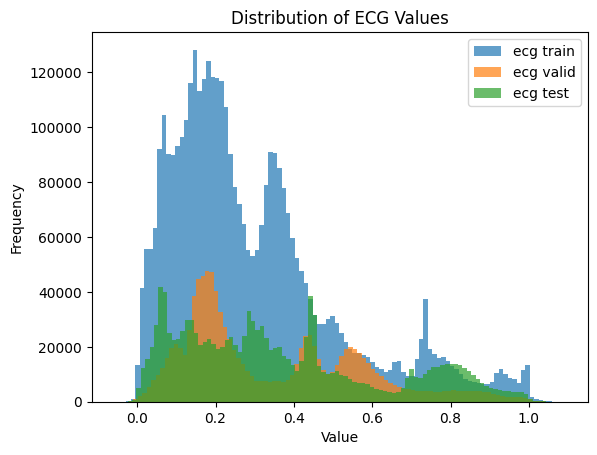

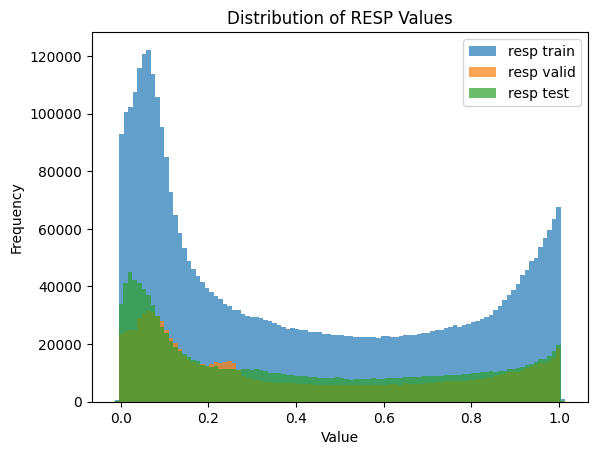

In [35]:
seconds_window = 8
downsampled_window_size = 1024 # signal size
window_size = sampling_rate * seconds_window # window size to split by

windows_ecg_train, windows_resp_train = process_data_segment(data, window_size, downsampled_window_size, train_patients)
windows_ecg_validation, windows_resp_validation = process_data_segment(data, window_size, downsampled_window_size, val_patients)
windows_ecg_test, windows_resp_test = process_data_segment(data, window_size, downsampled_window_size, test_patients)

plt.hist(windows_ecg_train.flatten(), bins=100, alpha=0.7, label="ecg train")
plt.hist(windows_ecg_validation.flatten(), bins=100, alpha=0.7, label="ecg valid")
plt.hist(windows_ecg_test.flatten(), bins=100, alpha=0.7, label="ecg test")
plt.title('Distribution of ECG Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

plt.hist(windows_resp_train.flatten(), bins=100, alpha=0.7, label="resp train")
plt.hist(windows_resp_validation.flatten(), bins=100, alpha=0.7, label="resp valid")
plt.hist(windows_resp_test.flatten(), bins=100, alpha=0.7, label="resp test")
plt.title('Distribution of RESP Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## Data Visualisation

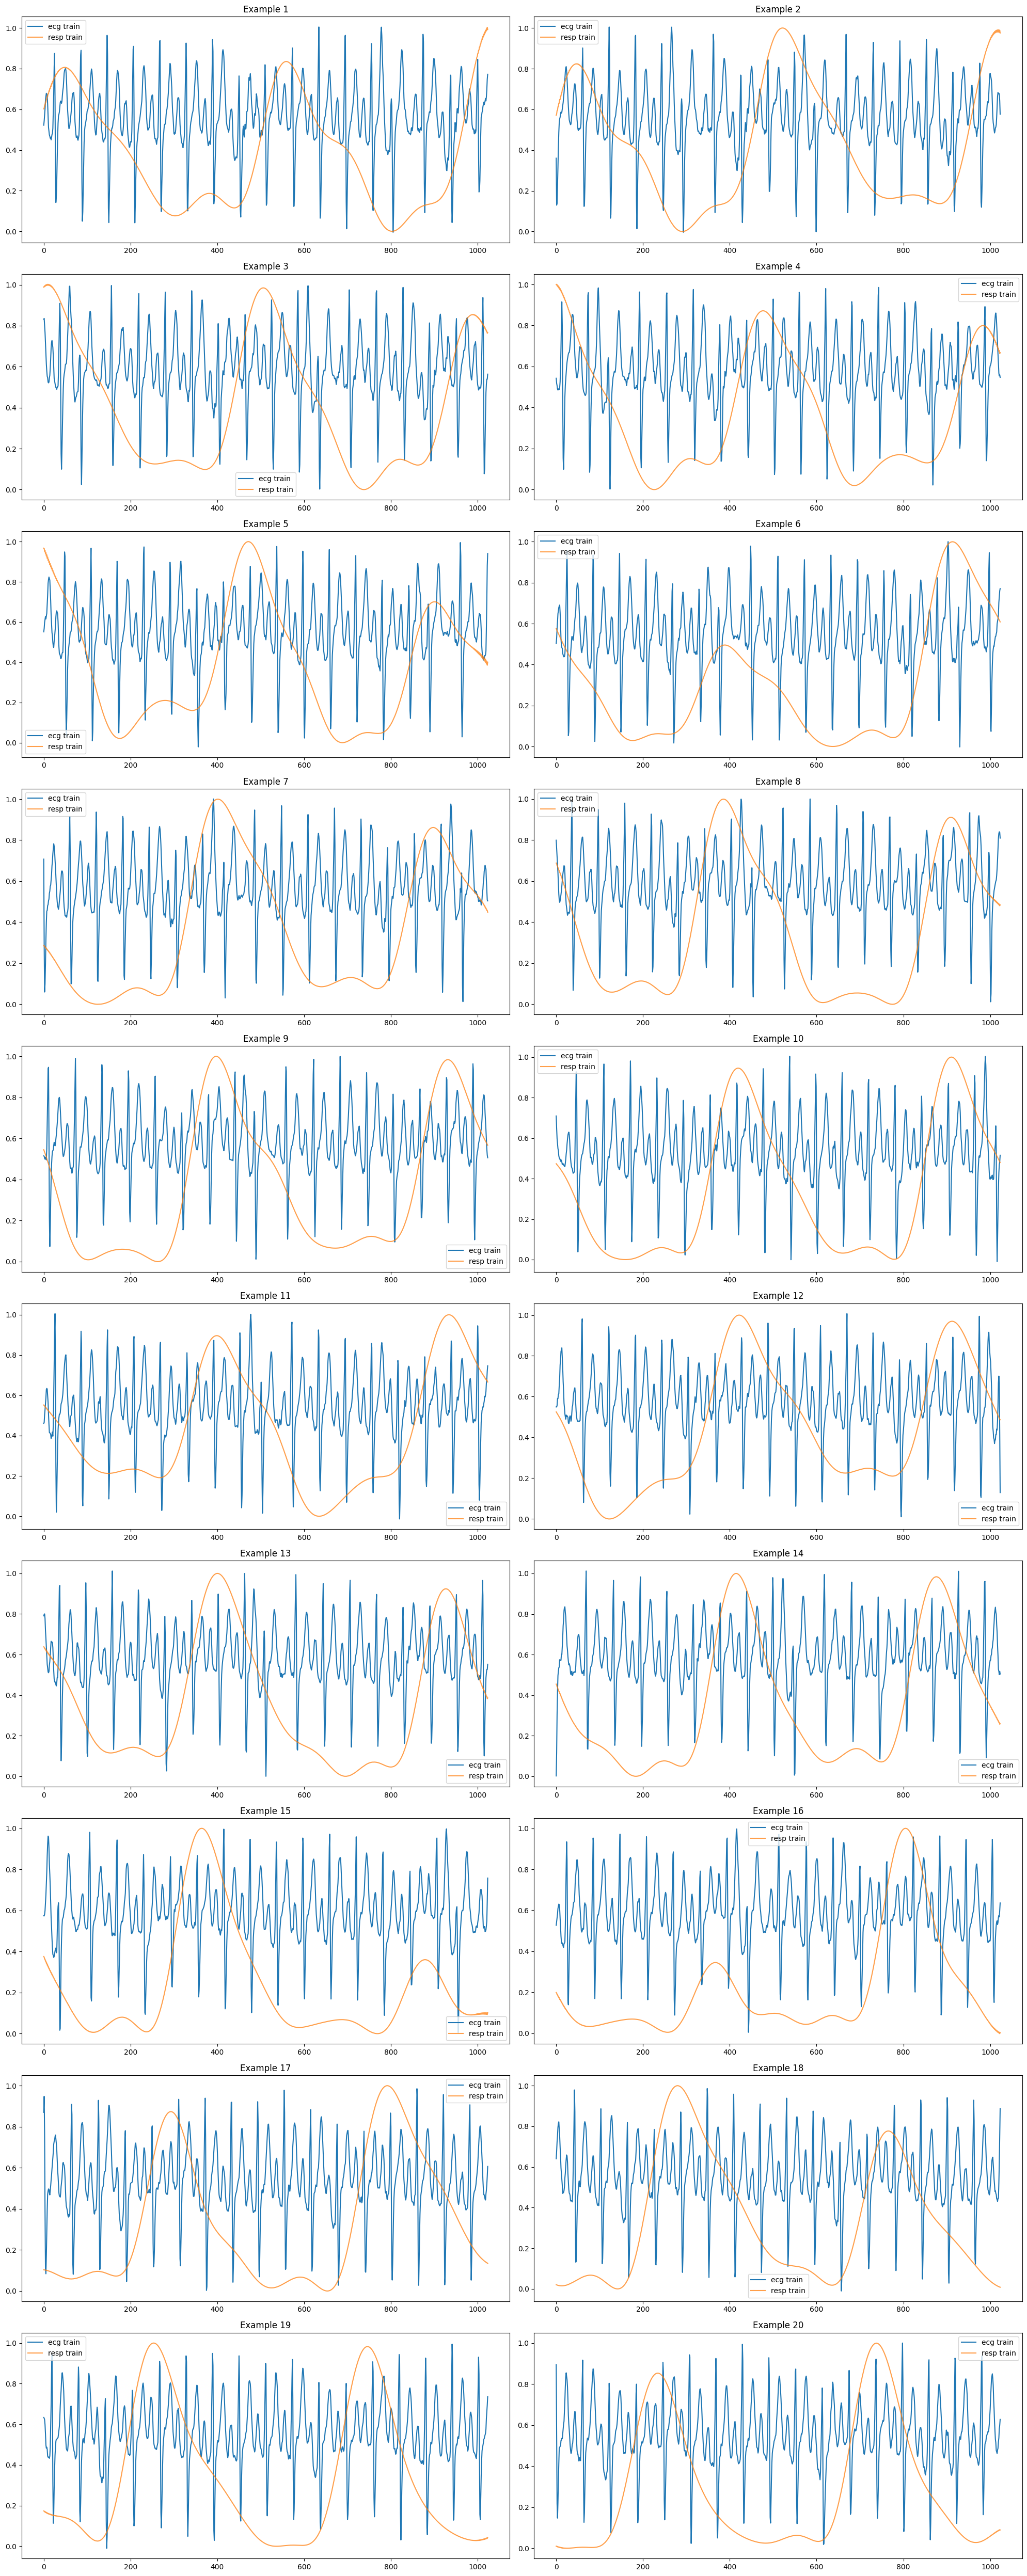

In [36]:
# train
plot_signals_in_grid(windows_ecg_train[0:20], windows_resp_train[0:20], labels=['ecg train', 'resp train'])

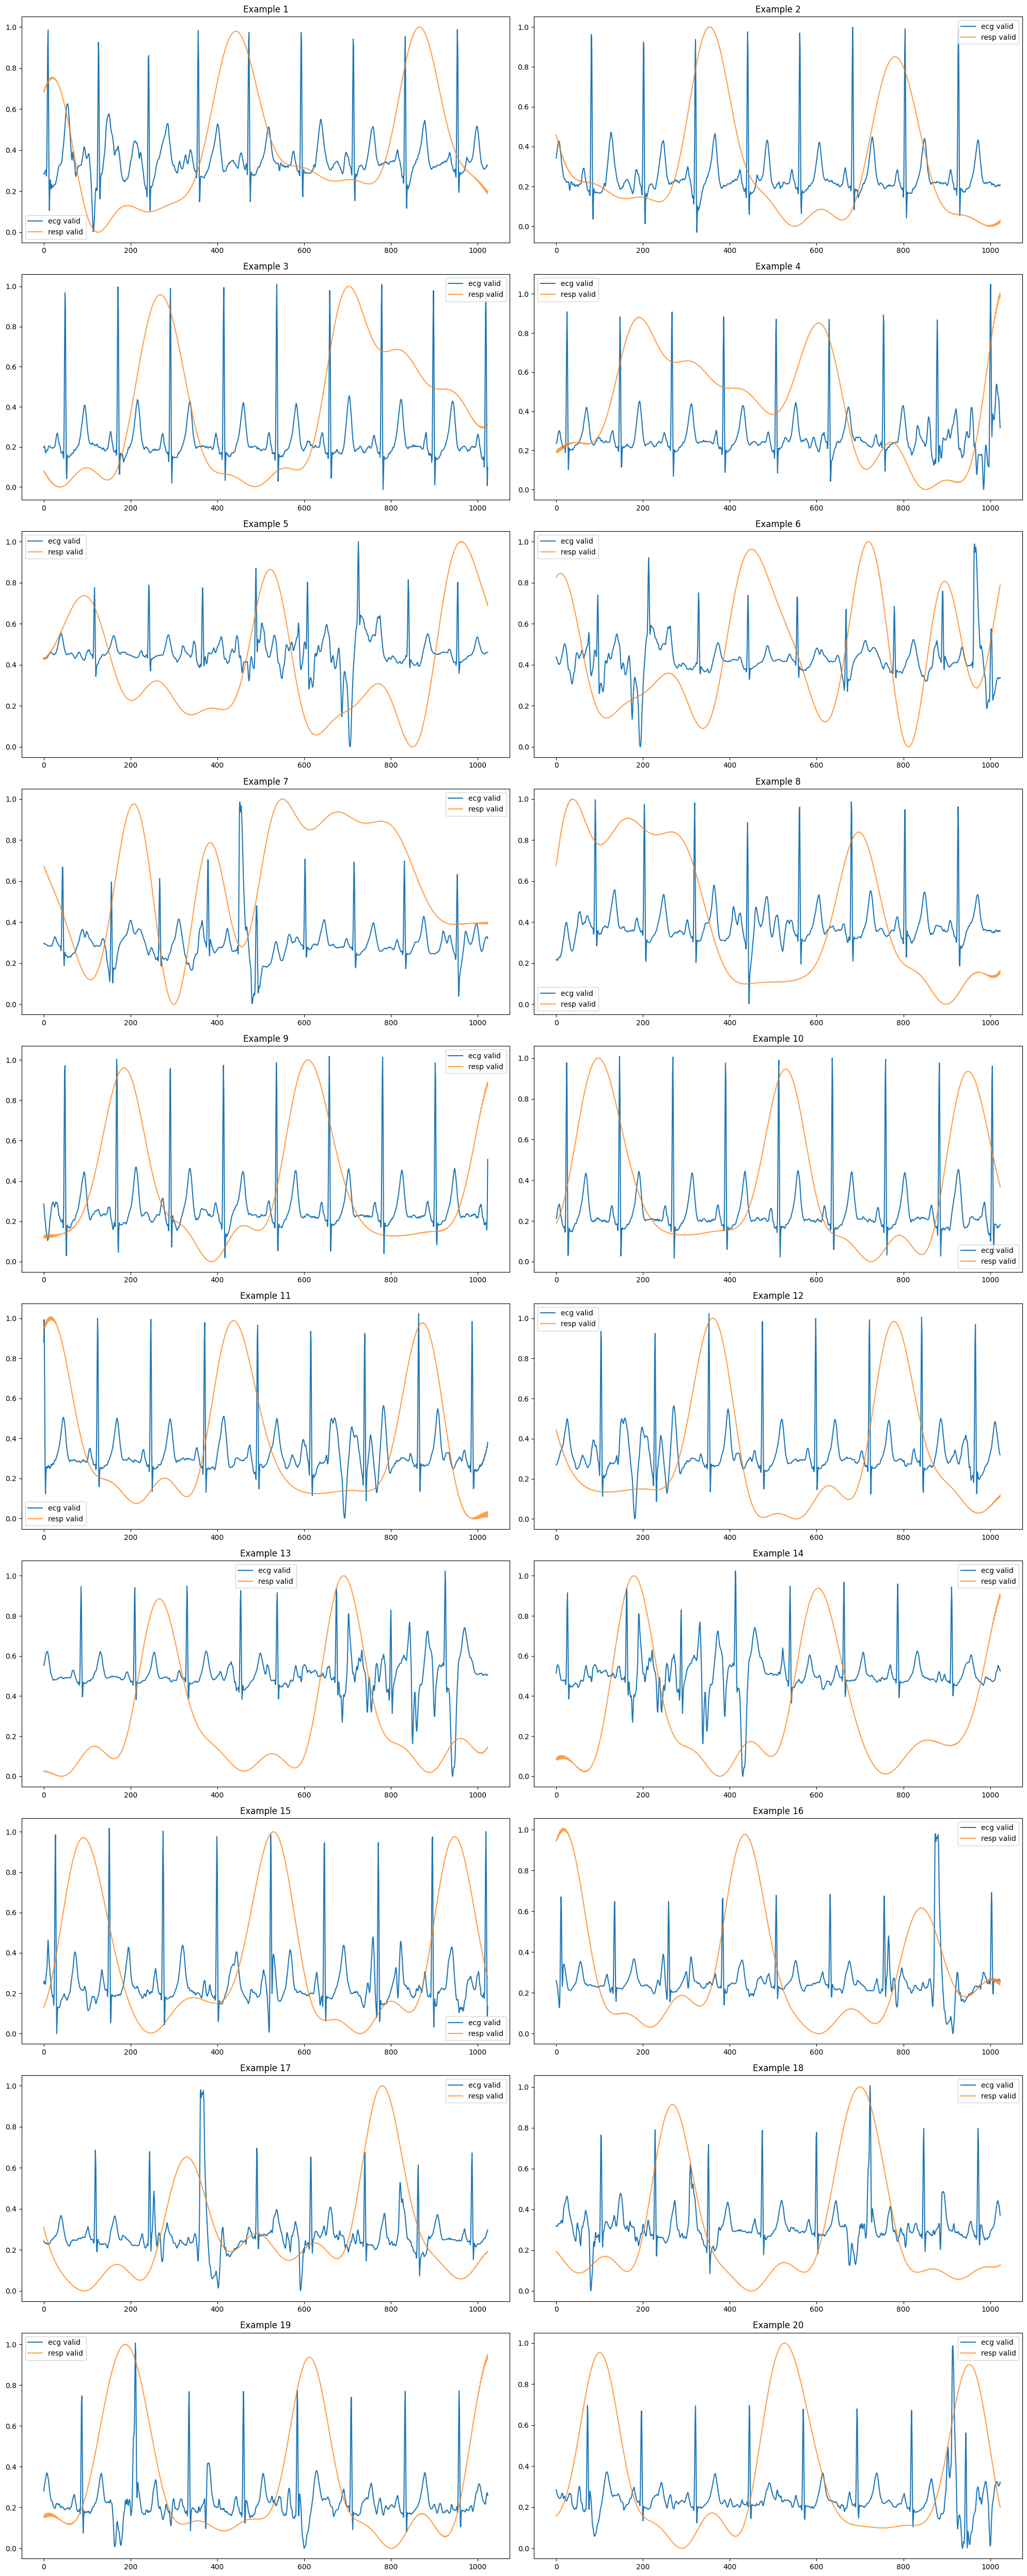

In [37]:
# valid
plot_signals_in_grid(windows_ecg_validation[0:20], windows_resp_validation[0:20], labels=['ecg valid', 'resp valid'])

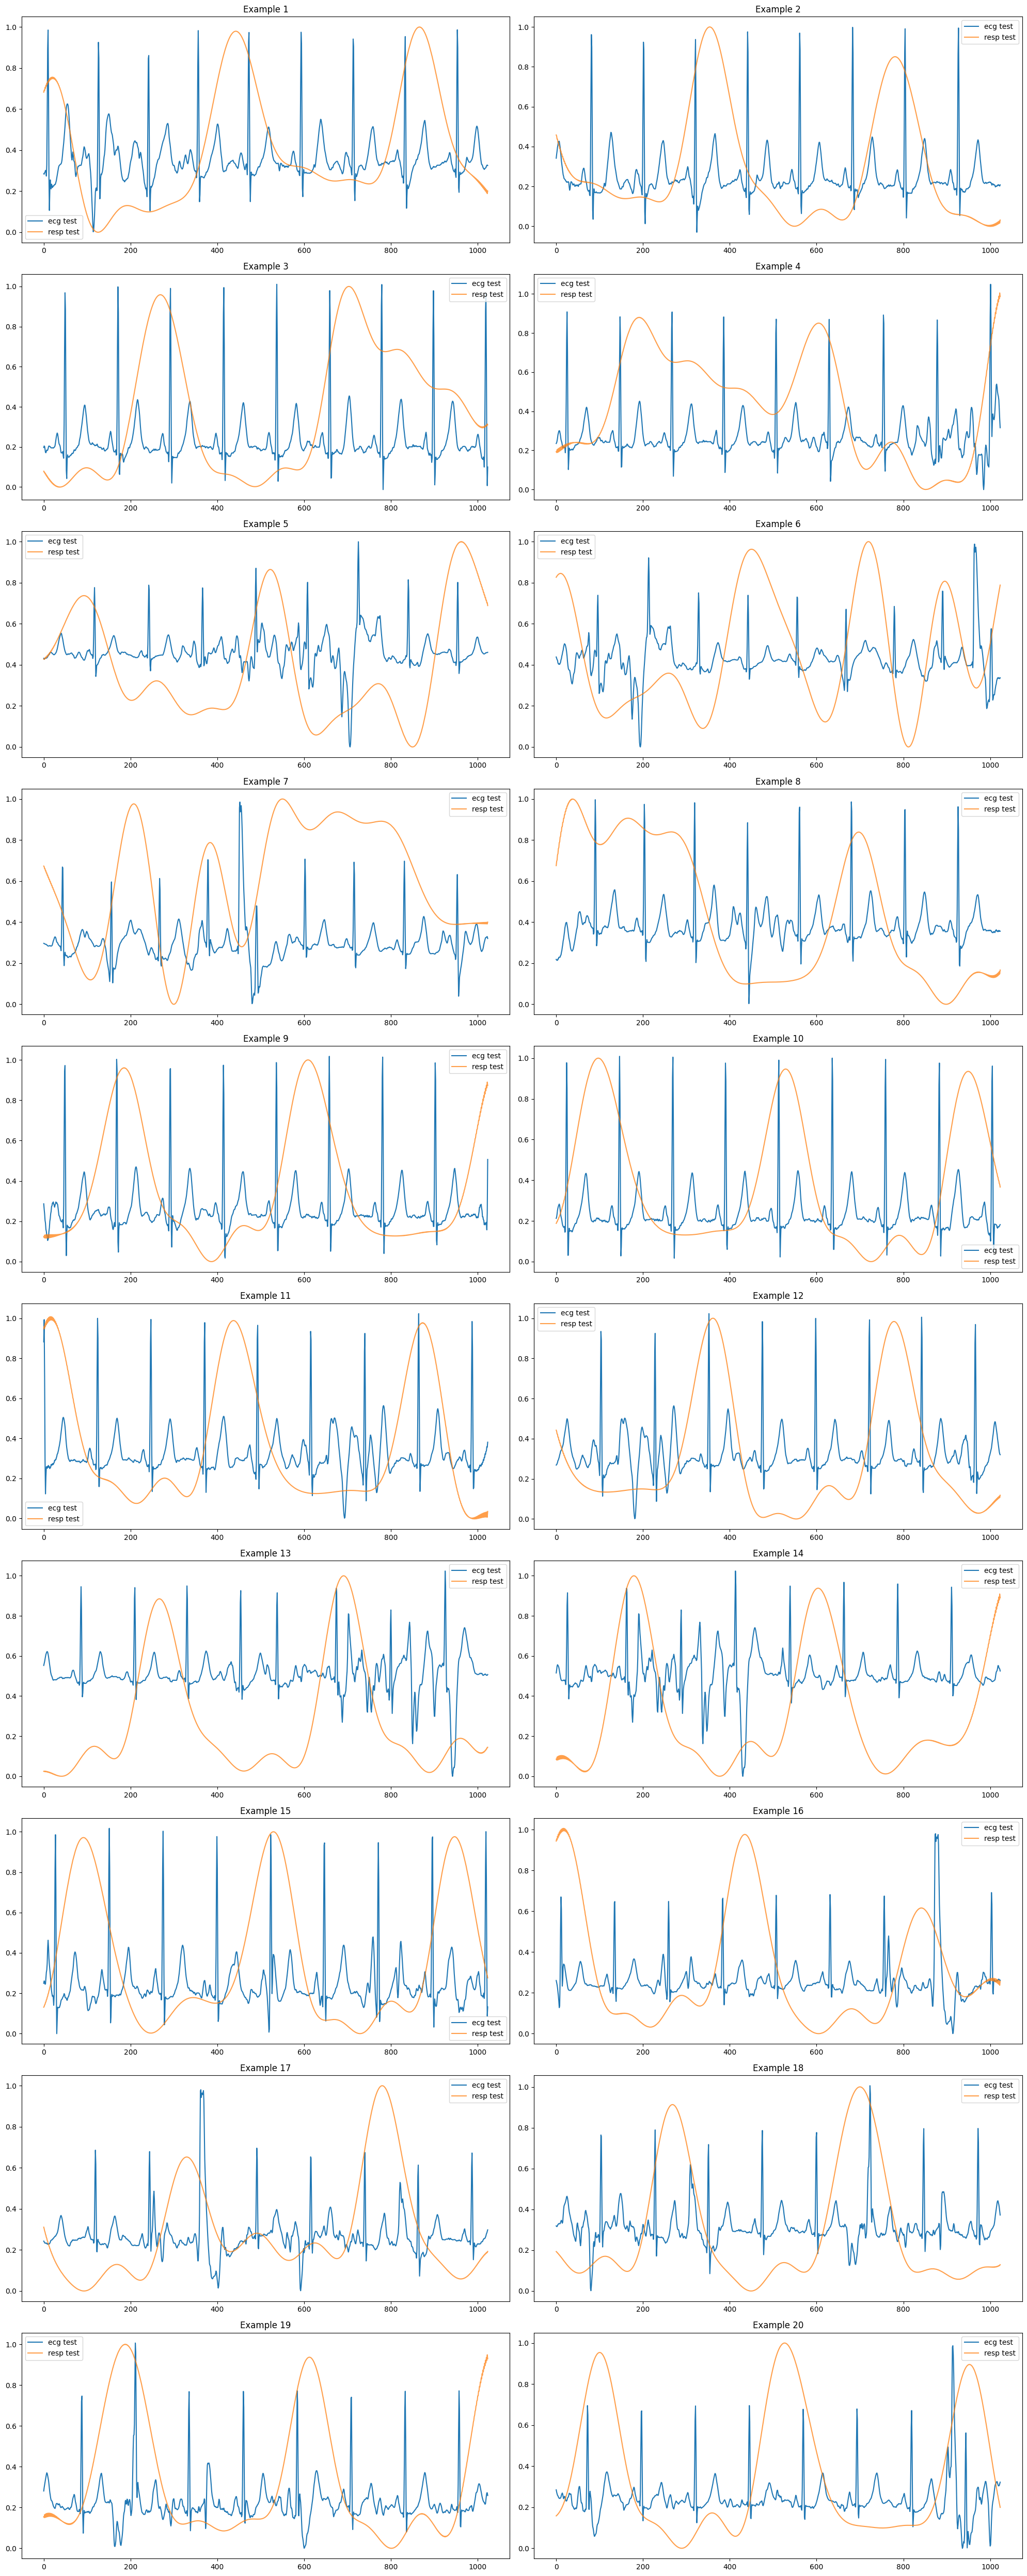

In [38]:
# test
plot_signals_in_grid(windows_ecg_test[0:20], windows_resp_test[0:20], labels=['ecg test', 'resp test'])

## CNN Autoencoder

In [39]:
if tf.config.list_physical_devices('GPU'):
    print("GPU enabled")
    with tf.device('/GPU:0'):
        windows_ecg_train = tf.convert_to_tensor(windows_ecg_train, dtype=tf.float16)
        windows_resp_train = tf.convert_to_tensor(windows_resp_train, dtype=tf.float16)
        windows_ecg_validation = tf.convert_to_tensor(windows_ecg_validation, dtype=tf.float16)
        windows_resp_validation = tf.convert_to_tensor(windows_resp_validation, dtype=tf.float16)
        windows_ecg_test = tf.convert_to_tensor(windows_ecg_test, dtype=tf.float16)
        windows_resp_test = tf.convert_to_tensor(windows_resp_test, dtype=tf.float16)

GPU enabled


In [40]:
class ModelConfig:
    def __init__(self, kernel_size, reg, dropout, start_filters, batch_size, epochs, learning_rate, input_size):
        self.kernel_size = kernel_size
        self.reg = reg
        self.dropout = dropout
        self.start_filters = start_filters
        self.batch_size = batch_size
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.input_size = input_size

    def __getitem__(self, item):
        return getattr(self, item)

    def __setitem__(self, key, value):
        setattr(self, key, value)

In [41]:
def create_model(config):
    kernel_size = config['kernel_size']
    regularizer = regularizers.l2(config['reg'])
    dropout_rate = config['dropout']
    size_0 = config['start_filters']

    # Input layer
    in_data = layers.Input(shape=(config['input_size'], 1))

    # Encoder part
    conv0 = layers.Conv1D(size_0, kernel_size, kernel_regularizer=regularizer, activation='relu', padding='same', kernel_initializer='he_normal')(in_data)
    conv0 = layers.BatchNormalization()(conv0)
    conv0 = layers.Conv1D(size_0, kernel_size, kernel_regularizer=regularizer, activation='relu', padding='same', kernel_initializer='he_normal')(conv0)
    conv0 = layers.BatchNormalization()(conv0)
    pool0 = layers.MaxPooling1D(pool_size=2)(conv0)

    size_1 = size_0 * 2
    conv1 = layers.Conv1D(size_1, kernel_size, kernel_regularizer=regularizer, activation='relu', padding='same', kernel_initializer='he_normal')(pool0)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Conv1D(size_1, kernel_size, kernel_regularizer=regularizer, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    conv1 = layers.BatchNormalization()(conv1)
    conv1 = layers.Dropout(dropout_rate)(conv1)
    pool1 = layers.MaxPooling1D(pool_size=2)(conv1)

    size_2 = size_1 * 2
    conv2 = layers.Conv1D(size_2, kernel_size, kernel_regularizer=regularizer, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = layers.BatchNormalization()(conv2)
    conv2 = layers.Conv1D(size_2, kernel_size, kernel_regularizer=regularizer, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    conv2 = layers.BatchNormalization()(conv2)

    # Decoder part
    up1 = layers.UpSampling1D(size=2)(conv2)
    up_conv1 = layers.Conv1D(size_2, 2, activation='relu', padding='same', kernel_initializer='he_normal')(up1)
    up_conv1 = layers.BatchNormalization()(up_conv1)
    merge1 = layers.concatenate([conv1, up_conv1], axis=2)
    conv3 = layers.Conv1D(size_1, kernel_size, kernel_regularizer=regularizer, activation='relu', padding='same', kernel_initializer='he_normal')(merge1)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Conv1D(size_1, kernel_size, kernel_regularizer=regularizer, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    conv3 = layers.BatchNormalization()(conv3)
    conv3 = layers.Dropout(dropout_rate)(conv3)

    up2 = layers.UpSampling1D(size=2)(conv3)
    up_conv2 = layers.Conv1D(size_1, 2, activation='relu', padding='same', kernel_initializer='he_normal')(up2)
    up_conv2 = layers.BatchNormalization()(up_conv2)
    merge2 = layers.concatenate([conv0, up_conv2], axis=2)
    conv4 = layers.Conv1D(size_0, kernel_size, kernel_regularizer=regularizer, activation='relu', padding='same', kernel_initializer='he_normal')(merge2)
    conv4 = layers.BatchNormalization()(conv4)
    conv4 = layers.Conv1D(size_0, kernel_size, kernel_regularizer=regularizer, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)
    conv4 = layers.BatchNormalization()(conv4)

    # Output layer
    out_data = layers.Conv1D(1, kernel_size, activation='sigmoid', padding='same')(conv4)
    #out_data = layers.Conv1D(1, kernel_size, activation='linear', padding='same')(conv4)

    model = models.Model(inputs=[in_data], outputs=[out_data])
    model.summary()

    return model

## Model tuning

In [42]:
def create_sweep_config():
    return {
        'method': 'random',
        'metric': {
            'name': 'val_loss',
            'goal': 'minimize'
        },
        'parameters': {
            'learning_rate': {
                'min': 1e-5,
                'max': 1e-2
            },
            'batch_size': {
                'values': [256, 512]
            },
            'kernel_size': {
                'values': [27]
            },
            'reg': {
                'min': 1e-5,
                'max': 1e-2
            },
            'dropout': {
                'min': 0.1,
                'max': 0.6
            },
            'start_filters': {
                'values': [8]
            },
            'input_size': {
                'values': [1024]
            }
        }
    }

In [45]:
def train(config=None):
    if config:
        wandb.init(config=config)
    else:
        wandb.init()
        config = wandb.config

    lr = wandb.config.learning_rate
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr, beta_1=0.9, beta_2=0.999, amsgrad=False)
    
    model = create_model(config)
    
    # define callbacks
    #reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, cooldown=5, mode='min', min_lr=1e-7)
    #filepath = os.path.join('Users/lanacaldarevic/ecg_derived_resp_dl/models', f'model_crossval{split_ind}-size{start_filters}-input{input_size}_weights-improvement.h5')
    #checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    
    # early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, start_from_epoch=20)
    lambda_cb = LambdaCallback(on_epoch_end=lambda epoch, logs: log_images(model, epoch, logs, fixed_sample_ecg_train, fixed_sample_resp_train, fixed_sample_ecg_valid, fixed_sample_resp_valid))

    callbacks = [wandb.keras.WandbCallback(),
                 early_stopping,
                VisualiseCallback(windows_ecg_train, windows_resp_train, windows_ecg_validation, windows_resp_validation)]
    model.compile(loss='mse', metrics=[cross_correlation], optimizer=optimizer)
    
    print("Model training starting")
    model.fit(windows_ecg_train, windows_resp_train,
              epochs=200,
              batch_size=wandb.config.batch_size,
              shuffle=True,
              callbacks=callbacks,
              validation_data=(windows_ecg_validation, windows_resp_validation))
    
    wandb.finish()

In [ ]:
sweep_config = create_sweep_config()
sweep_id = wandb.sweep(sweep_config, project="bidmc-hp-tuning")

wandb.agent(sweep_id, train)

Create sweep with ID: 4l38p2cz
Sweep URL: https://wandb.ai/lana-caldarevic1/bidmc-hp-tuning/sweeps/4l38p2cz


wandb: Agent Starting Run: wgdcz00m with config:
wandb: 	batch_size: 512
wandb: 	dropout: 0.22817407502712797
wandb: 	input_size: 1024
wandb: 	kernel_size: 27
wandb: 	learning_rate: 0.009433294603388875
wandb: 	reg: 0.007333615043828872
wandb: 	start_filters: 8


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1024, 1)]            0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 1024, 8)              224       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 1024, 8)              32        ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv1d_1 (Conv1D)           (None, 1024, 8)              1736      ['batch_normalization[0][0

2024-05-24 08:52:17.893528: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - ETA: 0s - loss: 1.3945 - cross_correlation: -0.0017

2024-05-24 08:52:32.938913: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085210-wgdcz00m/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085210-wgdcz00m/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085210-wgdcz00m/files/model-best)... Done. 0.1s
2024-05-24 08:52:38.022892: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 819ms/step


2024-05-24 08:52:38.853613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 25s 2s/step - loss: 1.3945 - cross_correlation: -0.0017 - val_loss: 0.5118 - val_cross_correlation: 0.0104
Epoch 2/200
8/8 [==============================] - ETA: 0s - loss: 0.3819 - cross_correlation: 0.0266

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085210-wgdcz00m/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085210-wgdcz00m/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085210-wgdcz00m/files/model-best)... Done. 0.0s


8/8 [==============================] - 8s 1s/step - loss: 0.3819 - cross_correlation: 0.0266 - val_loss: 0.2819 - val_cross_correlation: 0.0116
Epoch 3/200
8/8 [==============================] - ETA: 0s - loss: 0.2638 - cross_correlation: 0.0370

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085210-wgdcz00m/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085210-wgdcz00m/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085210-wgdcz00m/files/model-best)... Done. 0.0s


8/8 [==============================] - 7s 901ms/step - loss: 0.2638 - cross_correlation: 0.0370 - val_loss: 0.2250 - val_cross_correlation: -0.0054
Epoch 4/200
8/8 [==============================] - ETA: 0s - loss: 0.2062 - cross_correlation: 0.0300

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085210-wgdcz00m/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085210-wgdcz00m/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085210-wgdcz00m/files/model-best)... Done. 0.0s


8/8 [==============================] - 7s 860ms/step - loss: 0.2062 - cross_correlation: 0.0300 - val_loss: 0.1780 - val_cross_correlation: 0.0226
Epoch 5/200
8/8 [==============================] - ETA: 0s - loss: 0.1728 - cross_correlation: 0.0074 

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085210-wgdcz00m/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085210-wgdcz00m/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085210-wgdcz00m/files/model-best)... Done. 0.0s


8/8 [==============================] - 6s 805ms/step - loss: 0.1728 - cross_correlation: 0.0074 - val_loss: 0.1507 - val_cross_correlation: -0.0014
Epoch 6/200
8/8 [==============================] - 4s 498ms/step - loss: 0.1484 - cross_correlation: 0.0235 - val_loss: 0.1535 - val_cross_correlation: -0.0013
Epoch 7/200
8/8 [==============================] - ETA: 0s - loss: 0.1565 - cross_correlation: 0.0035

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085210-wgdcz00m/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085210-wgdcz00m/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085210-wgdcz00m/files/model-best)... Done. 0.0s


8/8 [==============================] - 6s 845ms/step - loss: 0.1565 - cross_correlation: 0.0035 - val_loss: 0.1358 - val_cross_correlation: 0.0035
Epoch 8/200
8/8 [==============================] - ETA: 0s - loss: 0.1354 - cross_correlation: -0.0098

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085210-wgdcz00m/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085210-wgdcz00m/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085210-wgdcz00m/files/model-best)... Done. 0.0s


8/8 [==============================] - 7s 832ms/step - loss: 0.1354 - cross_correlation: -0.0098 - val_loss: 0.1304 - val_cross_correlation: 4.2659e-05
Epoch 9/200
8/8 [==============================] - ETA: 0s - loss: 0.1303 - cross_correlation: -8.6766e-04

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085210-wgdcz00m/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085210-wgdcz00m/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085210-wgdcz00m/files/model-best)... Done. 0.0s


8/8 [==============================] - 6s 831ms/step - loss: 0.1303 - cross_correlation: -8.6766e-04 - val_loss: 0.1237 - val_cross_correlation: 8.0739e-04
Epoch 10/200
8/8 [==============================] - 4s 500ms/step - loss: 0.1349 - cross_correlation: -0.0013 - val_loss: 0.1459 - val_cross_correlation: 0.0046
Epoch 11/200
8/8 [==============================] - 4s 484ms/step - loss: 0.1429 - cross_correlation: -0.0027 - val_loss: 0.1286 - val_cross_correlation: 0.0052
Epoch 12/200
8/8 [==============================] - 4s 498ms/step - loss: 0.1320 - cross_correlation: 7.9189e-05 - val_loss: 0.1338 - val_cross_correlation: 0.0040
Epoch 13/200
8/8 [==============================] - 4s 496ms/step - loss: 0.1326 - cross_correlation: -0.0057 - val_loss: 0.1249 - val_cross_correlation: 0.0057
Epoch 14/200
8/8 [==============================] - 4s 490ms/step - loss: 0.1366 - cross_correlation: -0.0014 - val_loss: 0.1464 - val_cross_correlation: 0.0051
Epoch 15/200
8/8 [==================

wandb: Agent Starting Run: eohquot3 with config:
wandb: 	batch_size: 256
wandb: 	dropout: 0.5043827385474812
wandb: 	input_size: 1024
wandb: 	kernel_size: 27
wandb: 	learning_rate: 0.0008948599668419244
wandb: 	reg: 0.001848084539559074
wandb: 	start_filters: 8


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1024, 1)]            0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 1024, 8)              224       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 1024, 8)              32        ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv1d_1 (Conv1D)           (None, 1024, 8)              1736      ['batch_normalization[0][0

2024-05-24 08:55:19.239409: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - ETA: 0s - loss: 0.6785 - cross_correlation: -6.5488e-04

2024-05-24 08:55:39.152873: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best)... Done. 0.0s
2024-05-24 08:55:43.944839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 753ms/step


2024-05-24 08:55:44.754411: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 29s 1s/step - loss: 0.6785 - cross_correlation: -6.5488e-04 - val_loss: 0.5616 - val_cross_correlation: 0.0042
Epoch 2/200
16/16 [==============================] - ETA: 0s - loss: 0.5111 - cross_correlation: 0.0094

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best)... Done. 0.0s


16/16 [==============================] - 7s 452ms/step - loss: 0.5111 - cross_correlation: 0.0094 - val_loss: 0.4360 - val_cross_correlation: 0.0057
Epoch 3/200
16/16 [==============================] - ETA: 0s - loss: 0.3946 - cross_correlation: 0.0560

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best)... Done. 0.0s


16/16 [==============================] - 8s 493ms/step - loss: 0.3946 - cross_correlation: 0.0560 - val_loss: 0.3433 - val_cross_correlation: 0.0045
Epoch 4/200
16/16 [==============================] - ETA: 0s - loss: 0.3121 - cross_correlation: 0.1667

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best)... Done. 0.0s


16/16 [==============================] - 7s 461ms/step - loss: 0.3121 - cross_correlation: 0.1667 - val_loss: 0.2813 - val_cross_correlation: -0.0017
Epoch 5/200
16/16 [==============================] - ETA: 0s - loss: 0.2551 - cross_correlation: 0.3149

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best)... Done. 0.0s


16/16 [==============================] - 7s 446ms/step - loss: 0.2551 - cross_correlation: 0.3149 - val_loss: 0.2462 - val_cross_correlation: 5.5515e-04
Epoch 6/200
16/16 [==============================] - ETA: 0s - loss: 0.2142 - cross_correlation: 0.4245

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best)... Done. 0.0s


16/16 [==============================] - 7s 456ms/step - loss: 0.2142 - cross_correlation: 0.4245 - val_loss: 0.2249 - val_cross_correlation: -0.0051
Epoch 7/200
16/16 [==============================] - ETA: 0s - loss: 0.1866 - cross_correlation: 0.4957

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best)... Done. 0.0s


16/16 [==============================] - 7s 469ms/step - loss: 0.1866 - cross_correlation: 0.4957 - val_loss: 0.2083 - val_cross_correlation: -0.0032
Epoch 8/200
16/16 [==============================] - ETA: 0s - loss: 0.1674 - cross_correlation: 0.5343

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best)... Done. 0.0s


16/16 [==============================] - 10s 607ms/step - loss: 0.1674 - cross_correlation: 0.5343 - val_loss: 0.1978 - val_cross_correlation: -0.0061
Epoch 9/200
16/16 [==============================] - ETA: 0s - loss: 0.1517 - cross_correlation: 0.5714

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best)... Done. 0.0s


16/16 [==============================] - 10s 596ms/step - loss: 0.1517 - cross_correlation: 0.5714 - val_loss: 0.1891 - val_cross_correlation: 0.0126
Epoch 10/200
16/16 [==============================] - ETA: 0s - loss: 0.1398 - cross_correlation: 0.6018

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best)... Done. 0.0s


16/16 [==============================] - 7s 452ms/step - loss: 0.1398 - cross_correlation: 0.6018 - val_loss: 0.1846 - val_cross_correlation: 0.0156
Epoch 11/200
16/16 [==============================] - ETA: 0s - loss: 0.1312 - cross_correlation: 0.6197

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best)... Done. 0.0s


16/16 [==============================] - 9s 550ms/step - loss: 0.1312 - cross_correlation: 0.6197 - val_loss: 0.1786 - val_cross_correlation: 0.0095
Epoch 12/200
16/16 [==============================] - ETA: 0s - loss: 0.1216 - cross_correlation: 0.6501

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best)... Done. 0.0s


16/16 [==============================] - 8s 494ms/step - loss: 0.1216 - cross_correlation: 0.6501 - val_loss: 0.1723 - val_cross_correlation: -0.0023
Epoch 13/200
16/16 [==============================] - ETA: 0s - loss: 0.1149 - cross_correlation: 0.6658

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best)... Done. 0.0s


16/16 [==============================] - 7s 433ms/step - loss: 0.1149 - cross_correlation: 0.6658 - val_loss: 0.1712 - val_cross_correlation: 0.0123
Epoch 14/200
16/16 [==============================] - ETA: 0s - loss: 0.1130 - cross_correlation: 0.6624

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best)... Done. 0.0s


16/16 [==============================] - 7s 458ms/step - loss: 0.1130 - cross_correlation: 0.6624 - val_loss: 0.1652 - val_cross_correlation: 0.0087
Epoch 15/200
16/16 [==============================] - ETA: 0s - loss: 0.1068 - cross_correlation: 0.6807

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best)... Done. 0.0s


16/16 [==============================] - 7s 424ms/step - loss: 0.1068 - cross_correlation: 0.6807 - val_loss: 0.1634 - val_cross_correlation: 0.0060
Epoch 16/200
16/16 [==============================] - ETA: 0s - loss: 0.1014 - cross_correlation: 0.7008

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best)... Done. 0.0s


16/16 [==============================] - 7s 419ms/step - loss: 0.1014 - cross_correlation: 0.7008 - val_loss: 0.1621 - val_cross_correlation: 0.0224
Epoch 17/200
16/16 [==============================] - ETA: 0s - loss: 0.0988 - cross_correlation: 0.7067

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best)... Done. 0.0s


16/16 [==============================] - 7s 452ms/step - loss: 0.0988 - cross_correlation: 0.7067 - val_loss: 0.1576 - val_cross_correlation: 0.0076
Epoch 18/200
16/16 [==============================] - 5s 292ms/step - loss: 0.0943 - cross_correlation: 0.7201 - val_loss: 0.1649 - val_cross_correlation: -0.0078
Epoch 19/200
16/16 [==============================] - ETA: 0s - loss: 0.0924 - cross_correlation: 0.7149

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best)... Done. 0.0s


16/16 [==============================] - 7s 444ms/step - loss: 0.0924 - cross_correlation: 0.7149 - val_loss: 0.1550 - val_cross_correlation: 0.0168
Epoch 20/200
16/16 [==============================] - 5s 304ms/step - loss: 0.0906 - cross_correlation: 0.7221 - val_loss: 0.1653 - val_cross_correlation: 0.0285
Epoch 21/200
16/16 [==============================] - 5s 346ms/step - loss: 0.0886 - cross_correlation: 0.7312 - val_loss: 0.1561 - val_cross_correlation: 0.0084
Epoch 22/200
16/16 [==============================] - 5s 286ms/step - loss: 0.0861 - cross_correlation: 0.7377 - val_loss: 0.1587 - val_cross_correlation: 0.0201
Epoch 23/200
16/16 [==============================] - ETA: 0s - loss: 0.0827 - cross_correlation: 0.7454

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best)... Done. 0.0s


16/16 [==============================] - 7s 424ms/step - loss: 0.0827 - cross_correlation: 0.7454 - val_loss: 0.1516 - val_cross_correlation: 0.0051
Epoch 24/200
16/16 [==============================] - ETA: 0s - loss: 0.0831 - cross_correlation: 0.7457

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best)... Done. 0.0s


16/16 [==============================] - 7s 420ms/step - loss: 0.0831 - cross_correlation: 0.7457 - val_loss: 0.1508 - val_cross_correlation: 0.0213
Epoch 25/200
16/16 [==============================] - 4s 272ms/step - loss: 0.0803 - cross_correlation: 0.7544 - val_loss: 0.2138 - val_cross_correlation: 0.0578
Epoch 26/200
16/16 [==============================] - 4s 285ms/step - loss: 0.0789 - cross_correlation: 0.7545 - val_loss: 0.1850 - val_cross_correlation: 0.0854
Epoch 27/200
16/16 [==============================] - ETA: 0s - loss: 0.0775 - cross_correlation: 0.7609

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best)... Done. 0.0s


16/16 [==============================] - 7s 422ms/step - loss: 0.0775 - cross_correlation: 0.7609 - val_loss: 0.1499 - val_cross_correlation: 0.0447
Epoch 28/200
16/16 [==============================] - ETA: 0s - loss: 0.0749 - cross_correlation: 0.7709

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best)... Done. 0.0s


16/16 [==============================] - 7s 425ms/step - loss: 0.0749 - cross_correlation: 0.7709 - val_loss: 0.1490 - val_cross_correlation: 0.0660
Epoch 29/200
16/16 [==============================] - 5s 297ms/step - loss: 0.0751 - cross_correlation: 0.7642 - val_loss: 0.1547 - val_cross_correlation: 0.0449
Epoch 30/200
16/16 [==============================] - 4s 268ms/step - loss: 0.0751 - cross_correlation: 0.7620 - val_loss: 0.1622 - val_cross_correlation: 0.0389
Epoch 31/200
16/16 [==============================] - ETA: 0s - loss: 0.0718 - cross_correlation: 0.7742

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best)... Done. 0.0s


16/16 [==============================] - 7s 434ms/step - loss: 0.0718 - cross_correlation: 0.7742 - val_loss: 0.1480 - val_cross_correlation: 0.0937
Epoch 32/200
16/16 [==============================] - ETA: 0s - loss: 0.0704 - cross_correlation: 0.7787

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best)... Done. 0.0s


16/16 [==============================] - 7s 415ms/step - loss: 0.0704 - cross_correlation: 0.7787 - val_loss: 0.1451 - val_cross_correlation: 0.0806
Epoch 33/200
16/16 [==============================] - 4s 280ms/step - loss: 0.0700 - cross_correlation: 0.7821 - val_loss: 0.1488 - val_cross_correlation: 0.0939
Epoch 34/200
16/16 [==============================] - 5s 288ms/step - loss: 0.0694 - cross_correlation: 0.7818 - val_loss: 0.1475 - val_cross_correlation: 0.0875
Epoch 35/200
16/16 [==============================] - 4s 269ms/step - loss: 0.0683 - cross_correlation: 0.7863 - val_loss: 0.1728 - val_cross_correlation: 0.1145
Epoch 36/200
16/16 [==============================] - 4s 267ms/step - loss: 0.0680 - cross_correlation: 0.7834 - val_loss: 0.1454 - val_cross_correlation: 0.1072
Epoch 37/200
16/16 [==============================] - ETA: 0s - loss: 0.0672 - cross_correlation: 0.7868

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_085511-eohquot3/files/model-best)... Done. 0.0s


16/16 [==============================] - 7s 416ms/step - loss: 0.0672 - cross_correlation: 0.7868 - val_loss: 0.1451 - val_cross_correlation: 0.1819
Epoch 38/200
16/16 [==============================] - 4s 263ms/step - loss: 0.0668 - cross_correlation: 0.7833 - val_loss: 0.1481 - val_cross_correlation: 0.1076
Epoch 39/200
16/16 [==============================] - 4s 275ms/step - loss: 0.0648 - cross_correlation: 0.7924 - val_loss: 0.1547 - val_cross_correlation: 0.0897
Epoch 40/200
16/16 [==============================] - 5s 303ms/step - loss: 0.0648 - cross_correlation: 0.7934 - val_loss: 0.1563 - val_cross_correlation: 0.1155
Epoch 41/200
16/16 [==============================] - 5s 337ms/step - loss: 0.0634 - cross_correlation: 0.8023 - val_loss: 0.1510 - val_cross_correlation: 0.1644
Epoch 42/200
16/16 [==============================] - 5s 297ms/step - loss: 0.0623 - cross_correlation: 0.8021 - val_loss: 0.1640 - val_cross_correlation: 0.1331
Epoch 43/200
16/16 [=====================

wandb: Agent Starting Run: qk4h39fi with config:
wandb: 	batch_size: 512
wandb: 	dropout: 0.4956902870106502
wandb: 	input_size: 1024
wandb: 	kernel_size: 27
wandb: 	learning_rate: 0.0020157320203187563
wandb: 	reg: 0.0001270757702898302
wandb: 	start_filters: 8


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1024, 1)]            0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 1024, 8)              224       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 1024, 8)              32        ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv1d_1 (Conv1D)           (None, 1024, 8)              1736      ['batch_normalization[0][0

2024-05-24 09:00:43.134179: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - ETA: 0s - loss: 0.1917 - cross_correlation: 0.0051

2024-05-24 09:01:00.837730: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090036-qk4h39fi/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090036-qk4h39fi/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090036-qk4h39fi/files/model-best)... Done. 0.0s
2024-05-24 09:01:05.232814: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 830ms/step


2024-05-24 09:01:06.100280: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 26s 2s/step - loss: 0.1917 - cross_correlation: 0.0051 - val_loss: 0.3112 - val_cross_correlation: -0.0047
Epoch 2/200
8/8 [==============================] - ETA: 0s - loss: 0.1614 - cross_correlation: 0.0022    

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090036-qk4h39fi/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090036-qk4h39fi/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090036-qk4h39fi/files/model-best)... Done. 0.0s


8/8 [==============================] - 7s 885ms/step - loss: 0.1614 - cross_correlation: 0.0022 - val_loss: 0.3055 - val_cross_correlation: -0.0062
Epoch 3/200
8/8 [==============================] - 4s 541ms/step - loss: 0.1510 - cross_correlation: 0.0515 - val_loss: 0.3389 - val_cross_correlation: 0.0399
Epoch 4/200
8/8 [==============================] - 4s 556ms/step - loss: 0.1436 - cross_correlation: 0.0992 - val_loss: 0.3092 - val_cross_correlation: 0.0128
Epoch 5/200
8/8 [==============================] - ETA: 0s - loss: 0.1389 - cross_correlation: 0.1162

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090036-qk4h39fi/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090036-qk4h39fi/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090036-qk4h39fi/files/model-best)... Done. 0.0s


8/8 [==============================] - 6s 814ms/step - loss: 0.1389 - cross_correlation: 0.1162 - val_loss: 0.1677 - val_cross_correlation: 0.0030
Epoch 6/200
8/8 [==============================] - ETA: 0s - loss: 0.1331 - cross_correlation: 0.1563

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090036-qk4h39fi/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090036-qk4h39fi/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090036-qk4h39fi/files/model-best)... Done. 0.0s


8/8 [==============================] - 7s 858ms/step - loss: 0.1331 - cross_correlation: 0.1563 - val_loss: 0.1525 - val_cross_correlation: -0.0066
Epoch 7/200
8/8 [==============================] - ETA: 0s - loss: 0.1274 - cross_correlation: 0.1914

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090036-qk4h39fi/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090036-qk4h39fi/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090036-qk4h39fi/files/model-best)... Done. 0.0s


8/8 [==============================] - 7s 923ms/step - loss: 0.1274 - cross_correlation: 0.1914 - val_loss: 0.1375 - val_cross_correlation: 0.0150
Epoch 8/200
8/8 [==============================] - 5s 571ms/step - loss: 0.1210 - cross_correlation: 0.2560 - val_loss: 0.1405 - val_cross_correlation: 0.0078
Epoch 9/200
8/8 [==============================] - 5s 616ms/step - loss: 0.1161 - cross_correlation: 0.3136 - val_loss: 0.1487 - val_cross_correlation: 0.0253
Epoch 10/200
8/8 [==============================] - 5s 641ms/step - loss: 0.1106 - cross_correlation: 0.3758 - val_loss: 0.1382 - val_cross_correlation: 0.0094
Epoch 11/200
8/8 [==============================] - 4s 555ms/step - loss: 0.1050 - cross_correlation: 0.4369 - val_loss: 0.1389 - val_cross_correlation: -0.0124
Epoch 12/200
8/8 [==============================] - 4s 531ms/step - loss: 0.0995 - cross_correlation: 0.4831 - val_loss: 0.1379 - val_cross_correlation: -0.0271
Epoch 13/200
8/8 [==============================] - 4

wandb: Agent Starting Run: rdqx7a5i with config:
wandb: 	batch_size: 512
wandb: 	dropout: 0.4199157720757564
wandb: 	input_size: 1024
wandb: 	kernel_size: 27
wandb: 	learning_rate: 0.00898883750963032
wandb: 	reg: 0.009999991332089748
wandb: 	start_filters: 8


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1024, 1)]            0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 1024, 8)              224       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 1024, 8)              32        ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv1d_1 (Conv1D)           (None, 1024, 8)              1736      ['batch_normalization[0][0

2024-05-24 09:04:25.160842: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - ETA: 0s - loss: 1.8538 - cross_correlation: 8.6822e-04

2024-05-24 09:04:56.291393: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090417-rdqx7a5i/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090417-rdqx7a5i/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090417-rdqx7a5i/files/model-best)... Done. 0.0s
2024-05-24 09:05:01.282785: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step


2024-05-24 09:05:03.647645: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 43s 4s/step - loss: 1.8538 - cross_correlation: 8.6822e-04 - val_loss: 0.6603 - val_cross_correlation: -0.0055
Epoch 2/200
8/8 [==============================] - ETA: 0s - loss: 0.4791 - cross_correlation: 0.0083

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090417-rdqx7a5i/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090417-rdqx7a5i/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090417-rdqx7a5i/files/model-best)... Done. 0.0s


8/8 [==============================] - 9s 1s/step - loss: 0.4791 - cross_correlation: 0.0083 - val_loss: 0.3452 - val_cross_correlation: -0.0051
Epoch 3/200
8/8 [==============================] - ETA: 0s - loss: 0.3098 - cross_correlation: 0.0234

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090417-rdqx7a5i/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090417-rdqx7a5i/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090417-rdqx7a5i/files/model-best)... Done. 0.0s


8/8 [==============================] - 9s 1s/step - loss: 0.3098 - cross_correlation: 0.0234 - val_loss: 0.2588 - val_cross_correlation: -0.0091
Epoch 4/200
8/8 [==============================] - ETA: 0s - loss: 0.2456 - cross_correlation: 0.0595

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090417-rdqx7a5i/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090417-rdqx7a5i/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090417-rdqx7a5i/files/model-best)... Done. 0.0s


8/8 [==============================] - 9s 1s/step - loss: 0.2456 - cross_correlation: 0.0595 - val_loss: 0.2041 - val_cross_correlation: -0.0089
Epoch 5/200
8/8 [==============================] - ETA: 0s - loss: 0.1943 - cross_correlation: 0.0232

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090417-rdqx7a5i/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090417-rdqx7a5i/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090417-rdqx7a5i/files/model-best)... Done. 0.0s


8/8 [==============================] - 7s 896ms/step - loss: 0.1943 - cross_correlation: 0.0232 - val_loss: 0.1806 - val_cross_correlation: -0.0143
Epoch 6/200
8/8 [==============================] - ETA: 0s - loss: 0.1781 - cross_correlation: 0.0028    

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090417-rdqx7a5i/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090417-rdqx7a5i/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090417-rdqx7a5i/files/model-best)... Done. 0.0s


8/8 [==============================] - 8s 1s/step - loss: 0.1781 - cross_correlation: 0.0028 - val_loss: 0.1575 - val_cross_correlation: -0.0098
Epoch 7/200
8/8 [==============================] - ETA: 0s - loss: 0.1559 - cross_correlation: -0.0016

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090417-rdqx7a5i/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090417-rdqx7a5i/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090417-rdqx7a5i/files/model-best)... Done. 0.0s


8/8 [==============================] - 7s 874ms/step - loss: 0.1559 - cross_correlation: -0.0016 - val_loss: 0.1418 - val_cross_correlation: -0.0113
Epoch 8/200
8/8 [==============================] - ETA: 0s - loss: 0.1414 - cross_correlation: -0.0026    

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090417-rdqx7a5i/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090417-rdqx7a5i/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090417-rdqx7a5i/files/model-best)... Done. 0.0s


8/8 [==============================] - 7s 881ms/step - loss: 0.1414 - cross_correlation: -0.0026 - val_loss: 0.1361 - val_cross_correlation: -0.0071
Epoch 9/200
8/8 [==============================] - 4s 569ms/step - loss: 0.1351 - cross_correlation: 0.0085 - val_loss: 0.1375 - val_cross_correlation: -0.0044
Epoch 10/200
8/8 [==============================] - 4s 530ms/step - loss: 0.1549 - cross_correlation: 0.0060 - val_loss: 0.1366 - val_cross_correlation: 0.0036
Epoch 11/200
8/8 [==============================] - 4s 539ms/step - loss: 0.1349 - cross_correlation: 0.0027 - val_loss: 0.1363 - val_cross_correlation: -0.0050
Epoch 12/200
8/8 [==============================] - ETA: 0s - loss: 0.1368 - cross_correlation: 0.0062

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090417-rdqx7a5i/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090417-rdqx7a5i/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090417-rdqx7a5i/files/model-best)... Done. 0.0s


8/8 [==============================] - 7s 921ms/step - loss: 0.1368 - cross_correlation: 0.0062 - val_loss: 0.1279 - val_cross_correlation: -0.0023
Epoch 13/200
8/8 [==============================] - ETA: 0s - loss: 0.1318 - cross_correlation: -0.0025

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090417-rdqx7a5i/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090417-rdqx7a5i/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090417-rdqx7a5i/files/model-best)... Done. 0.0s


8/8 [==============================] - 6s 822ms/step - loss: 0.1318 - cross_correlation: -0.0025 - val_loss: 0.1259 - val_cross_correlation: -0.0050
Epoch 14/200
8/8 [==============================] - 4s 572ms/step - loss: 0.1312 - cross_correlation: 0.0012 - val_loss: 0.1284 - val_cross_correlation: -0.0013
Epoch 15/200
8/8 [==============================] - 5s 590ms/step - loss: 0.1314 - cross_correlation: 0.0071 - val_loss: 0.1277 - val_cross_correlation: -0.0030
Epoch 16/200
8/8 [==============================] - 4s 549ms/step - loss: 0.1311 - cross_correlation: 0.0046 - val_loss: 0.1374 - val_cross_correlation: 0.0113
Epoch 17/200
8/8 [==============================] - 4s 562ms/step - loss: 0.1382 - cross_correlation: -0.0044 - val_loss: 0.1280 - val_cross_correlation: 0.0038
Epoch 18/200
8/8 [==============================] - 5s 567ms/step - loss: 0.1378 - cross_correlation: 0.0034 - val_loss: 0.1383 - val_cross_correlation: -2.2652e-04
Epoch 19/200
8/8 [=========================

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090417-rdqx7a5i/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090417-rdqx7a5i/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090417-rdqx7a5i/files/model-best)... Done. 0.0s


8/8 [==============================] - 7s 984ms/step - loss: 0.1316 - cross_correlation: 0.0054 - val_loss: 0.1256 - val_cross_correlation: 0.0032
Epoch 21/200
8/8 [==============================] - 6s 809ms/step - loss: 0.1296 - cross_correlation: -0.0020 - val_loss: 0.1303 - val_cross_correlation: -0.0051
Epoch 22/200
8/8 [==============================] - ETA: 0s - loss: 0.1324 - cross_correlation: 0.0049

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090417-rdqx7a5i/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090417-rdqx7a5i/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090417-rdqx7a5i/files/model-best)... Done. 0.0s


8/8 [==============================] - 7s 880ms/step - loss: 0.1324 - cross_correlation: 0.0049 - val_loss: 0.1251 - val_cross_correlation: -0.0038
Epoch 23/200
8/8 [==============================] - 4s 540ms/step - loss: 0.1316 - cross_correlation: -0.0102 - val_loss: 0.1350 - val_cross_correlation: -0.0096
Epoch 24/200
8/8 [==============================] - 5s 588ms/step - loss: 0.1464 - cross_correlation: 2.6602e-04 - val_loss: 0.1382 - val_cross_correlation: -0.0065
Epoch 25/200
8/8 [==============================] - 4s 537ms/step - loss: 0.1527 - cross_correlation: -0.0085 - val_loss: 0.1475 - val_cross_correlation: -0.0090
Epoch 26/200
8/8 [==============================] - 4s 535ms/step - loss: 0.1468 - cross_correlation: 0.0047 - val_loss: 0.1419 - val_cross_correlation: -0.0061
Epoch 27/200
8/8 [==============================] - 4s 535ms/step - loss: 0.1463 - cross_correlation: 0.0023 - val_loss: 0.1364 - val_cross_correlation: 0.0060
Epoch 28/200
8/8 [========================

wandb: Agent Starting Run: 23xo70re with config:
wandb: 	batch_size: 512
wandb: 	dropout: 0.2718202443372463
wandb: 	input_size: 1024
wandb: 	kernel_size: 27
wandb: 	learning_rate: 0.0055152657129799295
wandb: 	reg: 0.004038649469135053
wandb: 	start_filters: 8


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1024, 1)]            0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 1024, 8)              224       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 1024, 8)              32        ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv1d_1 (Conv1D)           (None, 1024, 8)              1736      ['batch_normalization[0][0

2024-05-24 09:08:17.952709: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - ETA: 0s - loss: 1.0073 - cross_correlation: 0.0250

2024-05-24 09:08:43.838602: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090810-23xo70re/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090810-23xo70re/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090810-23xo70re/files/model-best)... Done. 0.0s
2024-05-24 09:08:50.000884: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step


2024-05-24 09:08:52.269108: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


8/8 [==============================] - 39s 4s/step - loss: 1.0073 - cross_correlation: 0.0250 - val_loss: 0.5532 - val_cross_correlation: 0.0279
Epoch 2/200
8/8 [==============================] - ETA: 0s - loss: 0.4063 - cross_correlation: 0.1256

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090810-23xo70re/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090810-23xo70re/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090810-23xo70re/files/model-best)... Done. 0.0s


8/8 [==============================] - 8s 984ms/step - loss: 0.4063 - cross_correlation: 0.1256 - val_loss: 0.2725 - val_cross_correlation: 0.0150
Epoch 3/200
8/8 [==============================] - ETA: 0s - loss: 0.2409 - cross_correlation: 0.1188

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090810-23xo70re/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090810-23xo70re/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090810-23xo70re/files/model-best)... Done. 0.0s


8/8 [==============================] - 7s 968ms/step - loss: 0.2409 - cross_correlation: 0.1188 - val_loss: 0.2099 - val_cross_correlation: -0.0061
Epoch 4/200
8/8 [==============================] - ETA: 0s - loss: 0.1986 - cross_correlation: 0.0861

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090810-23xo70re/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090810-23xo70re/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090810-23xo70re/files/model-best)... Done. 0.0s


8/8 [==============================] - 7s 894ms/step - loss: 0.1986 - cross_correlation: 0.0861 - val_loss: 0.1749 - val_cross_correlation: -0.0076
Epoch 5/200
8/8 [==============================] - ETA: 0s - loss: 0.1657 - cross_correlation: 0.1115

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090810-23xo70re/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090810-23xo70re/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090810-23xo70re/files/model-best)... Done. 0.0s


8/8 [==============================] - 7s 883ms/step - loss: 0.1657 - cross_correlation: 0.1115 - val_loss: 0.1512 - val_cross_correlation: -0.0066
Epoch 6/200
8/8 [==============================] - ETA: 0s - loss: 0.1504 - cross_correlation: 0.1663

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090810-23xo70re/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090810-23xo70re/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090810-23xo70re/files/model-best)... Done. 0.0s


8/8 [==============================] - 7s 944ms/step - loss: 0.1504 - cross_correlation: 0.1663 - val_loss: 0.1467 - val_cross_correlation: -0.0105
Epoch 7/200
8/8 [==============================] - ETA: 0s - loss: 0.1469 - cross_correlation: 0.1752

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090810-23xo70re/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090810-23xo70re/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090810-23xo70re/files/model-best)... Done. 0.0s


8/8 [==============================] - 7s 865ms/step - loss: 0.1469 - cross_correlation: 0.1752 - val_loss: 0.1450 - val_cross_correlation: -0.0169
Epoch 8/200
8/8 [==============================] - ETA: 0s - loss: 0.1402 - cross_correlation: 0.2481

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090810-23xo70re/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090810-23xo70re/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090810-23xo70re/files/model-best)... Done. 0.0s


8/8 [==============================] - 7s 915ms/step - loss: 0.1402 - cross_correlation: 0.2481 - val_loss: 0.1379 - val_cross_correlation: -0.0226
Epoch 9/200
8/8 [==============================] - ETA: 0s - loss: 0.1288 - cross_correlation: 0.3125

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090810-23xo70re/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090810-23xo70re/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090810-23xo70re/files/model-best)... Done. 0.0s


8/8 [==============================] - 8s 998ms/step - loss: 0.1288 - cross_correlation: 0.3125 - val_loss: 0.1367 - val_cross_correlation: -0.0131
Epoch 10/200
8/8 [==============================] - 5s 685ms/step - loss: 0.1289 - cross_correlation: 0.3211 - val_loss: 0.1426 - val_cross_correlation: -0.0168
Epoch 11/200
8/8 [==============================] - 5s 606ms/step - loss: 0.1261 - cross_correlation: 0.3727 - val_loss: 0.1411 - val_cross_correlation: -0.0010
Epoch 12/200
8/8 [==============================] - 5s 582ms/step - loss: 0.1232 - cross_correlation: 0.3892 - val_loss: 0.1401 - val_cross_correlation: -0.0134
Epoch 13/200
8/8 [==============================] - 5s 588ms/step - loss: 0.1233 - cross_correlation: 0.3758 - val_loss: 0.1498 - val_cross_correlation: -0.0250
Epoch 14/200
8/8 [==============================] - 5s 575ms/step - loss: 0.1190 - cross_correlation: 0.3855 - val_loss: 0.1435 - val_cross_correlation: -0.0204
Epoch 15/200
8/8 [=============================

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090810-23xo70re/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090810-23xo70re/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090810-23xo70re/files/model-best)... Done. 0.0s


8/8 [==============================] - 7s 870ms/step - loss: 0.0925 - cross_correlation: 0.5419 - val_loss: 0.1366 - val_cross_correlation: -0.0098
Epoch 29/200
8/8 [==============================] - 5s 582ms/step - loss: 0.0955 - cross_correlation: 0.5150 - val_loss: 0.1914 - val_cross_correlation: -0.0175
Epoch 30/200
8/8 [==============================] - 5s 588ms/step - loss: 0.1009 - cross_correlation: 0.5243 - val_loss: 0.1468 - val_cross_correlation: 0.0158
Epoch 31/200
8/8 [==============================] - 4s 551ms/step - loss: 0.0997 - cross_correlation: 0.5305 - val_loss: 0.2138 - val_cross_correlation: -0.0202
Epoch 32/200
8/8 [==============================] - 5s 599ms/step - loss: 0.0940 - cross_correlation: 0.5488 - val_loss: 0.1729 - val_cross_correlation: -0.0212
Epoch 33/200
8/8 [==============================] - 4s 561ms/step - loss: 0.0897 - cross_correlation: 0.5583 - val_loss: 0.1371 - val_cross_correlation: -0.0190
Epoch 34/200
8/8 [==============================

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090810-23xo70re/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090810-23xo70re/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_090810-23xo70re/files/model-best)... Done. 0.0s


8/8 [==============================] - 7s 900ms/step - loss: 0.0868 - cross_correlation: 0.5804 - val_loss: 0.1330 - val_cross_correlation: 0.0014
Epoch 39/200
8/8 [==============================] - 5s 576ms/step - loss: 0.0868 - cross_correlation: 0.5977 - val_loss: 0.1698 - val_cross_correlation: -0.0164
Epoch 40/200
8/8 [==============================] - 5s 599ms/step - loss: 0.0847 - cross_correlation: 0.6123 - val_loss: 0.1350 - val_cross_correlation: -0.0095
Epoch 41/200
8/8 [==============================] - 6s 774ms/step - loss: 0.0929 - cross_correlation: 0.5621 - val_loss: 0.1444 - val_cross_correlation: -0.0131
Epoch 42/200
8/8 [==============================] - 5s 675ms/step - loss: 0.1020 - cross_correlation: 0.5509 - val_loss: 0.2049 - val_cross_correlation: -0.0109
Epoch 43/200
8/8 [==============================] - 5s 629ms/step - loss: 0.0984 - cross_correlation: 0.5828 - val_loss: 0.2107 - val_cross_correlation: -0.0223
Epoch 44/200
8/8 [==============================

wandb: Agent Starting Run: 5g2x4kns with config:
wandb: 	batch_size: 256
wandb: 	dropout: 0.23771698471911137
wandb: 	input_size: 1024
wandb: 	kernel_size: 27
wandb: 	learning_rate: 0.00327486720948959
wandb: 	reg: 0.0019836953231358724
wandb: 	start_filters: 8


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1024, 1)]            0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 1024, 8)              224       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 1024, 8)              32        ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv1d_1 (Conv1D)           (None, 1024, 8)              1736      ['batch_normalization[0][0

2024-05-24 09:13:21.903462: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - ETA: 0s - loss: 0.5427 - cross_correlation: 0.0799

2024-05-24 09:14:06.885878: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_091314-5g2x4kns/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_091314-5g2x4kns/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_091314-5g2x4kns/files/model-best)... Done. 0.0s
2024-05-24 09:14:14.897820: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 2s 2s/step


2024-05-24 09:14:16.861191: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 60s 3s/step - loss: 0.5427 - cross_correlation: 0.0799 - val_loss: 0.3159 - val_cross_correlation: 0.0095
Epoch 2/200
16/16 [==============================] - ETA: 0s - loss: 0.2414 - cross_correlation: 0.3147

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_091314-5g2x4kns/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_091314-5g2x4kns/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_091314-5g2x4kns/files/model-best)... Done. 0.0s


16/16 [==============================] - 11s 684ms/step - loss: 0.2414 - cross_correlation: 0.3147 - val_loss: 0.2101 - val_cross_correlation: -0.0077
Epoch 3/200
16/16 [==============================] - ETA: 0s - loss: 0.1641 - cross_correlation: 0.4528

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_091314-5g2x4kns/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_091314-5g2x4kns/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_091314-5g2x4kns/files/model-best)... Done. 0.0s


16/16 [==============================] - 9s 555ms/step - loss: 0.1641 - cross_correlation: 0.4528 - val_loss: 0.1744 - val_cross_correlation: -0.0049
Epoch 4/200
16/16 [==============================] - ETA: 0s - loss: 0.1336 - cross_correlation: 0.5209

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_091314-5g2x4kns/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_091314-5g2x4kns/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_091314-5g2x4kns/files/model-best)... Done. 0.0s


16/16 [==============================] - 9s 588ms/step - loss: 0.1336 - cross_correlation: 0.5209 - val_loss: 0.1618 - val_cross_correlation: 0.0096
Epoch 5/200
16/16 [==============================] - ETA: 0s - loss: 0.1166 - cross_correlation: 0.5797

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_091314-5g2x4kns/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_091314-5g2x4kns/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_091314-5g2x4kns/files/model-best)... Done. 0.0s


16/16 [==============================] - 9s 574ms/step - loss: 0.1166 - cross_correlation: 0.5797 - val_loss: 0.1557 - val_cross_correlation: 0.0106
Epoch 6/200
16/16 [==============================] - ETA: 0s - loss: 0.1050 - cross_correlation: 0.6225

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_091314-5g2x4kns/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_091314-5g2x4kns/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_091314-5g2x4kns/files/model-best)... Done. 0.0s


16/16 [==============================] - 10s 620ms/step - loss: 0.1050 - cross_correlation: 0.6225 - val_loss: 0.1512 - val_cross_correlation: 0.0123
Epoch 7/200
16/16 [==============================] - ETA: 0s - loss: 0.1030 - cross_correlation: 0.6063

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_091314-5g2x4kns/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_091314-5g2x4kns/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_091314-5g2x4kns/files/model-best)... Done. 0.0s


16/16 [==============================] - 8s 523ms/step - loss: 0.1030 - cross_correlation: 0.6063 - val_loss: 0.1498 - val_cross_correlation: 0.0041
Epoch 8/200
16/16 [==============================] - ETA: 0s - loss: 0.0940 - cross_correlation: 0.6583

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_091314-5g2x4kns/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_091314-5g2x4kns/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_091314-5g2x4kns/files/model-best)... Done. 0.0s


16/16 [==============================] - 9s 547ms/step - loss: 0.0940 - cross_correlation: 0.6583 - val_loss: 0.1487 - val_cross_correlation: 8.0357e-04
Epoch 9/200
16/16 [==============================] - 7s 416ms/step - loss: 0.0900 - cross_correlation: 0.6637 - val_loss: 0.1500 - val_cross_correlation: -0.0110
Epoch 10/200
16/16 [==============================] - ETA: 0s - loss: 0.0878 - cross_correlation: 0.6806

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_091314-5g2x4kns/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_091314-5g2x4kns/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_091314-5g2x4kns/files/model-best)... Done. 0.0s


16/16 [==============================] - 9s 589ms/step - loss: 0.0878 - cross_correlation: 0.6806 - val_loss: 0.1444 - val_cross_correlation: -0.0046
Epoch 11/200
16/16 [==============================] - 8s 478ms/step - loss: 0.0851 - cross_correlation: 0.6960 - val_loss: 0.1521 - val_cross_correlation: -0.0094
Epoch 12/200
16/16 [==============================] - 7s 421ms/step - loss: 0.0814 - cross_correlation: 0.7165 - val_loss: 0.1493 - val_cross_correlation: 0.0041
Epoch 13/200
16/16 [==============================] - ETA: 0s - loss: 0.0789 - cross_correlation: 0.7223

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_091314-5g2x4kns/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_091314-5g2x4kns/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_091314-5g2x4kns/files/model-best)... Done. 0.0s


16/16 [==============================] - 9s 581ms/step - loss: 0.0789 - cross_correlation: 0.7223 - val_loss: 0.1418 - val_cross_correlation: -0.0106
Epoch 14/200
16/16 [==============================] - 8s 527ms/step - loss: 0.0764 - cross_correlation: 0.7329 - val_loss: 0.1499 - val_cross_correlation: -0.0174
Epoch 15/200
16/16 [==============================] - ETA: 0s - loss: 0.0754 - cross_correlation: 0.7334

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_091314-5g2x4kns/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_091314-5g2x4kns/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_091314-5g2x4kns/files/model-best)... Done. 0.0s


16/16 [==============================] - 7s 472ms/step - loss: 0.0754 - cross_correlation: 0.7334 - val_loss: 0.1395 - val_cross_correlation: -0.0178
Epoch 16/200
16/16 [==============================] - 5s 338ms/step - loss: 0.0743 - cross_correlation: 0.7432 - val_loss: 0.1444 - val_cross_correlation: -0.0090
Epoch 17/200
16/16 [==============================] - ETA: 0s - loss: 0.0722 - cross_correlation: 0.7480

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_091314-5g2x4kns/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_091314-5g2x4kns/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_091314-5g2x4kns/files/model-best)... Done. 0.0s


16/16 [==============================] - 7s 461ms/step - loss: 0.0722 - cross_correlation: 0.7480 - val_loss: 0.1393 - val_cross_correlation: -0.0054
Epoch 18/200
16/16 [==============================] - 5s 334ms/step - loss: 0.0746 - cross_correlation: 0.7436 - val_loss: 0.1662 - val_cross_correlation: -0.0076
Epoch 19/200
16/16 [==============================] - 5s 341ms/step - loss: 0.0715 - cross_correlation: 0.7464 - val_loss: 0.1427 - val_cross_correlation: -0.0634
Epoch 20/200
16/16 [==============================] - 5s 332ms/step - loss: 0.0718 - cross_correlation: 0.7442 - val_loss: 0.1422 - val_cross_correlation: -0.0100
Epoch 21/200
16/16 [==============================] - ETA: 0s - loss: 0.0699 - cross_correlation: 0.7480

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_091314-5g2x4kns/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_091314-5g2x4kns/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_091314-5g2x4kns/files/model-best)... Done. 0.0s


16/16 [==============================] - 37s 2s/step - loss: 0.0699 - cross_correlation: 0.7480 - val_loss: 0.1372 - val_cross_correlation: -0.0246
Epoch 22/200
16/16 [==============================] - 7s 451ms/step - loss: 0.0691 - cross_correlation: 0.7531 - val_loss: 0.1552 - val_cross_correlation: -0.0239
Epoch 23/200
16/16 [==============================] - 8s 497ms/step - loss: 0.0696 - cross_correlation: 0.7552 - val_loss: 0.1449 - val_cross_correlation: -0.0211
Epoch 24/200
16/16 [==============================] - 9s 546ms/step - loss: 0.0688 - cross_correlation: 0.7542 - val_loss: 0.1439 - val_cross_correlation: 0.0237
Epoch 25/200
16/16 [==============================] - 7s 417ms/step - loss: 0.0665 - cross_correlation: 0.7631 - val_loss: 0.1587 - val_cross_correlation: 0.0083
Epoch 26/200
16/16 [==============================] - 7s 401ms/step - loss: 0.0652 - cross_correlation: 0.7658 - val_loss: 0.1413 - val_cross_correlation: -0.0957
Epoch 27/200
16/16 [===================

wandb: Agent Starting Run: 68xtjwpy with config:
wandb: 	batch_size: 256
wandb: 	dropout: 0.2859104688317411
wandb: 	input_size: 1024
wandb: 	kernel_size: 27
wandb: 	learning_rate: 0.0051898334252924285
wandb: 	reg: 0.005708393358444406
wandb: 	start_filters: 8


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1024, 1)]            0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 1024, 8)              224       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 1024, 8)              32        ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv1d_1 (Conv1D)           (None, 1024, 8)              1736      ['batch_normalization[0][0

2024-05-24 09:18:53.093281: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - ETA: 0s - loss: 0.9774 - cross_correlation: 0.0333

2024-05-24 09:19:47.126131: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_091845-68xtjwpy/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_091845-68xtjwpy/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_091845-68xtjwpy/files/model-best)... Done. 0.0s
2024-05-24 09:19:56.460909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 3s 3s/step


2024-05-24 09:19:59.308758: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 72s 3s/step - loss: 0.9774 - cross_correlation: 0.0333 - val_loss: 0.3457 - val_cross_correlation: -7.9971e-04
Epoch 2/200
16/16 [==============================] - ETA: 0s - loss: 0.2591 - cross_correlation: 0.0605

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_091845-68xtjwpy/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_091845-68xtjwpy/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_091845-68xtjwpy/files/model-best)... Done. 0.0s


16/16 [==============================] - 12s 733ms/step - loss: 0.2591 - cross_correlation: 0.0605 - val_loss: 0.1957 - val_cross_correlation: -0.0050
Epoch 3/200
16/16 [==============================] - ETA: 0s - loss: 0.1765 - cross_correlation: 0.0474

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_091845-68xtjwpy/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_091845-68xtjwpy/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_091845-68xtjwpy/files/model-best)... Done. 0.0s


16/16 [==============================] - 11s 673ms/step - loss: 0.1765 - cross_correlation: 0.0474 - val_loss: 0.1598 - val_cross_correlation: 5.5428e-04
Epoch 4/200
16/16 [==============================] - ETA: 0s - loss: 0.1548 - cross_correlation: 0.0406

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_091845-68xtjwpy/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_091845-68xtjwpy/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_091845-68xtjwpy/files/model-best)... Done. 0.0s


16/16 [==============================] - 10s 627ms/step - loss: 0.1548 - cross_correlation: 0.0406 - val_loss: 0.1440 - val_cross_correlation: -0.0036
Epoch 5/200
16/16 [==============================] - ETA: 0s - loss: 0.1476 - cross_correlation: 0.0692

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_091845-68xtjwpy/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_091845-68xtjwpy/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_091845-68xtjwpy/files/model-best)... Done. 0.0s


16/16 [==============================] - 12s 781ms/step - loss: 0.1476 - cross_correlation: 0.0692 - val_loss: 0.1328 - val_cross_correlation: 0.0035
Epoch 6/200
16/16 [==============================] - 7s 442ms/step - loss: 0.1433 - cross_correlation: 0.1355 - val_loss: 0.1443 - val_cross_correlation: -0.0147
Epoch 7/200
16/16 [==============================] - 12s 763ms/step - loss: 0.1384 - cross_correlation: 0.2317 - val_loss: 0.1432 - val_cross_correlation: -0.0023
Epoch 8/200
16/16 [==============================] - 9s 552ms/step - loss: 0.1358 - cross_correlation: 0.2800 - val_loss: 0.1559 - val_cross_correlation: -0.0085
Epoch 9/200
16/16 [==============================] - 7s 429ms/step - loss: 0.1268 - cross_correlation: 0.3101 - val_loss: 0.1364 - val_cross_correlation: -0.0012
Epoch 10/200
16/16 [==============================] - 7s 456ms/step - loss: 0.1334 - cross_correlation: 0.2951 - val_loss: 0.1502 - val_cross_correlation: -0.0019
Epoch 11/200
16/16 [==================

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_091845-68xtjwpy/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_091845-68xtjwpy/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_091845-68xtjwpy/files/model-best)... Done. 0.0s


16/16 [==============================] - 10s 632ms/step - loss: 0.1210 - cross_correlation: 0.3352 - val_loss: 0.1315 - val_cross_correlation: -0.0177
Epoch 15/200
16/16 [==============================] - 7s 417ms/step - loss: 0.1210 - cross_correlation: 0.3313 - val_loss: 0.1727 - val_cross_correlation: -0.0135
Epoch 16/200
16/16 [==============================] - 7s 461ms/step - loss: 0.1335 - cross_correlation: 0.2813 - val_loss: 0.2012 - val_cross_correlation: -0.0041
Epoch 17/200
16/16 [==============================] - 7s 423ms/step - loss: 0.1276 - cross_correlation: 0.3297 - val_loss: 0.1677 - val_cross_correlation: 0.0163
Epoch 18/200
16/16 [==============================] - 8s 479ms/step - loss: 0.1298 - cross_correlation: 0.3201 - val_loss: 0.1426 - val_cross_correlation: -0.0151
Epoch 19/200
16/16 [==============================] - 7s 449ms/step - loss: 0.1338 - cross_correlation: 0.3120 - val_loss: 0.1381 - val_cross_correlation: -0.0010
Epoch 20/200
16/16 [===============

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_091845-68xtjwpy/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_091845-68xtjwpy/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_091845-68xtjwpy/files/model-best)... Done. 0.0s


16/16 [==============================] - 9s 554ms/step - loss: 0.1180 - cross_correlation: 0.3860 - val_loss: 0.1305 - val_cross_correlation: -0.0109
Epoch 23/200
16/16 [==============================] - 7s 474ms/step - loss: 0.1203 - cross_correlation: 0.3741 - val_loss: 0.1525 - val_cross_correlation: -0.0076
Epoch 24/200
16/16 [==============================] - 8s 474ms/step - loss: 0.1152 - cross_correlation: 0.3830 - val_loss: 0.1346 - val_cross_correlation: -0.0166
Epoch 25/200
16/16 [==============================] - 7s 462ms/step - loss: 0.1170 - cross_correlation: 0.3872 - val_loss: 0.1380 - val_cross_correlation: 0.0121
Epoch 26/200
16/16 [==============================] - 8s 502ms/step - loss: 0.1171 - cross_correlation: 0.3807 - val_loss: 0.1518 - val_cross_correlation: 0.0204
Epoch 27/200
16/16 [==============================] - 8s 479ms/step - loss: 0.1288 - cross_correlation: 0.3816 - val_loss: 0.1375 - val_cross_correlation: -0.0010
Epoch 28/200
16/16 [=================

wandb: Agent Starting Run: wwfjc40k with config:
wandb: 	batch_size: 256
wandb: 	dropout: 0.4786856932161747
wandb: 	input_size: 1024
wandb: 	kernel_size: 27
wandb: 	learning_rate: 0.00631581240208641
wandb: 	reg: 0.0060469177163153765
wandb: 	start_filters: 8


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1024, 1)]            0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 1024, 8)              224       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 1024, 8)              32        ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv1d_1 (Conv1D)           (None, 1024, 8)              1736      ['batch_normalization[0][0

2024-05-24 09:24:37.921009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - ETA: 0s - loss: 0.9316 - cross_correlation: 0.0184

2024-05-24 09:25:46.300648: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_092430-wwfjc40k/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_092430-wwfjc40k/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_092430-wwfjc40k/files/model-best)... Done. 0.0s
2024-05-24 09:25:55.982760: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 1s/step


2024-05-24 09:25:57.417408: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 84s 3s/step - loss: 0.9316 - cross_correlation: 0.0184 - val_loss: 0.3034 - val_cross_correlation: -0.0042
Epoch 2/200
16/16 [==============================] - ETA: 0s - loss: 0.2383 - cross_correlation: 0.1047

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_092430-wwfjc40k/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_092430-wwfjc40k/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_092430-wwfjc40k/files/model-best)... Done. 0.0s


16/16 [==============================] - 12s 675ms/step - loss: 0.2383 - cross_correlation: 0.1047 - val_loss: 0.1839 - val_cross_correlation: -0.0014
Epoch 3/200
16/16 [==============================] - ETA: 0s - loss: 0.1702 - cross_correlation: 0.1875

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_092430-wwfjc40k/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_092430-wwfjc40k/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_092430-wwfjc40k/files/model-best)... Done. 0.0s


16/16 [==============================] - 13s 811ms/step - loss: 0.1702 - cross_correlation: 0.1875 - val_loss: 0.1633 - val_cross_correlation: -0.0114
Epoch 4/200
16/16 [==============================] - ETA: 0s - loss: 0.1469 - cross_correlation: 0.2917

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_092430-wwfjc40k/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_092430-wwfjc40k/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_092430-wwfjc40k/files/model-best)... Done. 0.0s


16/16 [==============================] - 13s 821ms/step - loss: 0.1469 - cross_correlation: 0.2917 - val_loss: 0.1448 - val_cross_correlation: -0.0073
Epoch 5/200
16/16 [==============================] - ETA: 0s - loss: 0.1375 - cross_correlation: 0.3028

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_092430-wwfjc40k/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_092430-wwfjc40k/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_092430-wwfjc40k/files/model-best)... Done. 0.0s


16/16 [==============================] - 12s 731ms/step - loss: 0.1375 - cross_correlation: 0.3028 - val_loss: 0.1441 - val_cross_correlation: -0.0081
Epoch 6/200
16/16 [==============================] - 8s 527ms/step - loss: 0.1335 - cross_correlation: 0.3138 - val_loss: 0.1525 - val_cross_correlation: 0.0131
Epoch 7/200
16/16 [==============================] - 9s 545ms/step - loss: 0.1555 - cross_correlation: 0.2936 - val_loss: 0.1536 - val_cross_correlation: -9.5162e-04
Epoch 8/200
16/16 [==============================] - 8s 515ms/step - loss: 0.1368 - cross_correlation: 0.3116 - val_loss: 0.1564 - val_cross_correlation: 0.0016
Epoch 9/200
16/16 [==============================] - ETA: 0s - loss: 0.1393 - cross_correlation: 0.3268

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_092430-wwfjc40k/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_092430-wwfjc40k/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_092430-wwfjc40k/files/model-best)... Done. 0.0s


16/16 [==============================] - 11s 708ms/step - loss: 0.1393 - cross_correlation: 0.3268 - val_loss: 0.1425 - val_cross_correlation: -0.0105
Epoch 10/200
16/16 [==============================] - ETA: 0s - loss: 0.1285 - cross_correlation: 0.3364

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_092430-wwfjc40k/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_092430-wwfjc40k/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_092430-wwfjc40k/files/model-best)... Done. 0.0s


16/16 [==============================] - 11s 729ms/step - loss: 0.1285 - cross_correlation: 0.3364 - val_loss: 0.1416 - val_cross_correlation: -0.0129
Epoch 11/200
16/16 [==============================] - 7s 448ms/step - loss: 0.1327 - cross_correlation: 0.3608 - val_loss: 0.1544 - val_cross_correlation: -0.0061
Epoch 12/200
16/16 [==============================] - ETA: 0s - loss: 0.1331 - cross_correlation: 0.3768

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_092430-wwfjc40k/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_092430-wwfjc40k/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_092430-wwfjc40k/files/model-best)... Done. 0.0s


16/16 [==============================] - 11s 699ms/step - loss: 0.1331 - cross_correlation: 0.3768 - val_loss: 0.1410 - val_cross_correlation: -0.0135
Epoch 13/200
16/16 [==============================] - 8s 480ms/step - loss: 0.1251 - cross_correlation: 0.3671 - val_loss: 0.1488 - val_cross_correlation: -0.0124
Epoch 14/200
16/16 [==============================] - 8s 500ms/step - loss: 0.1260 - cross_correlation: 0.3574 - val_loss: 0.1609 - val_cross_correlation: -0.0108
Epoch 15/200
16/16 [==============================] - 8s 501ms/step - loss: 0.1256 - cross_correlation: 0.3584 - val_loss: 0.1537 - val_cross_correlation: -0.0132
Epoch 16/200
16/16 [==============================] - 9s 545ms/step - loss: 0.1227 - cross_correlation: 0.3629 - val_loss: 0.1418 - val_cross_correlation: -0.0093
Epoch 17/200
16/16 [==============================] - ETA: 0s - loss: 0.1283 - cross_correlation: 0.3870

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_092430-wwfjc40k/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_092430-wwfjc40k/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_092430-wwfjc40k/files/model-best)... Done. 0.0s


16/16 [==============================] - 12s 749ms/step - loss: 0.1283 - cross_correlation: 0.3870 - val_loss: 0.1406 - val_cross_correlation: -0.0026
Epoch 18/200
16/16 [==============================] - ETA: 0s - loss: 0.1178 - cross_correlation: 0.4015

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_092430-wwfjc40k/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_092430-wwfjc40k/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_092430-wwfjc40k/files/model-best)... Done. 0.0s


16/16 [==============================] - 12s 788ms/step - loss: 0.1178 - cross_correlation: 0.4015 - val_loss: 0.1317 - val_cross_correlation: -0.0044
Epoch 19/200
16/16 [==============================] - 6s 394ms/step - loss: 0.1145 - cross_correlation: 0.4029 - val_loss: 0.1393 - val_cross_correlation: 0.0032
Epoch 20/200
16/16 [==============================] - 7s 447ms/step - loss: 0.1121 - cross_correlation: 0.4115 - val_loss: 0.1323 - val_cross_correlation: 0.0022
Epoch 21/200
16/16 [==============================] - 11s 708ms/step - loss: 0.1153 - cross_correlation: 0.4071 - val_loss: 0.1378 - val_cross_correlation: -0.0116
Epoch 22/200
16/16 [==============================] - 8s 488ms/step - loss: 0.1095 - cross_correlation: 0.4339 - val_loss: 0.1323 - val_cross_correlation: -0.0147
Epoch 23/200
16/16 [==============================] - 7s 424ms/step - loss: 0.1130 - cross_correlation: 0.4265 - val_loss: 0.1371 - val_cross_correlation: -0.0106
Epoch 24/200
16/16 [===============

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_092430-wwfjc40k/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_092430-wwfjc40k/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_092430-wwfjc40k/files/model-best)... Done. 0.0s


16/16 [==============================] - 10s 640ms/step - loss: 0.1064 - cross_correlation: 0.4429 - val_loss: 0.1285 - val_cross_correlation: -3.0455e-04
Epoch 36/200
16/16 [==============================] - ETA: 0s - loss: 0.1040 - cross_correlation: 0.4432

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_092430-wwfjc40k/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_092430-wwfjc40k/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_092430-wwfjc40k/files/model-best)... Done. 0.0s


16/16 [==============================] - 11s 663ms/step - loss: 0.1040 - cross_correlation: 0.4432 - val_loss: 0.1279 - val_cross_correlation: -0.0160
Epoch 37/200
16/16 [==============================] - 7s 436ms/step - loss: 0.1030 - cross_correlation: 0.4399 - val_loss: 0.1312 - val_cross_correlation: -0.0125
Epoch 38/200
16/16 [==============================] - 9s 562ms/step - loss: 0.1024 - cross_correlation: 0.4575 - val_loss: 0.1281 - val_cross_correlation: -0.0173
Epoch 39/200
16/16 [==============================] - 9s 537ms/step - loss: 0.1005 - cross_correlation: 0.4538 - val_loss: 0.1709 - val_cross_correlation: -0.0094
Epoch 40/200
16/16 [==============================] - 9s 583ms/step - loss: 0.1105 - cross_correlation: 0.4226 - val_loss: 0.1365 - val_cross_correlation: -0.0145
Epoch 41/200
16/16 [==============================] - 10s 653ms/step - loss: 0.1122 - cross_correlation: 0.4415 - val_loss: 0.1557 - val_cross_correlation: 0.2013
Epoch 42/200
16/16 [==============

wandb: Agent Starting Run: h4epk3fj with config:
wandb: 	batch_size: 256
wandb: 	dropout: 0.121172175954489
wandb: 	input_size: 1024
wandb: 	kernel_size: 27
wandb: 	learning_rate: 0.0025256944926958093
wandb: 	reg: 0.004772104126740404
wandb: 	start_filters: 8


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1024, 1)]            0         []                            
                                                                                                  
 conv1d (Conv1D)             (None, 1024, 8)              224       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 1024, 8)              32        ['conv1d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 conv1d_1 (Conv1D)           (None, 1024, 8)              1736      ['batch_normalization[0][0

2024-05-24 09:33:09.993657: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - ETA: 0s - loss: 1.1694 - cross_correlation: 0.0575

2024-05-24 09:33:48.697126: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_093301-h4epk3fj/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_093301-h4epk3fj/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_093301-h4epk3fj/files/model-best)... Done. 0.0s
2024-05-24 09:33:59.121524: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 5s 5s/step


2024-05-24 09:34:03.928598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


16/16 [==============================] - 61s 3s/step - loss: 1.1694 - cross_correlation: 0.0575 - val_loss: 0.6847 - val_cross_correlation: 0.0052
Epoch 2/200
16/16 [==============================] - ETA: 0s - loss: 0.4882 - cross_correlation: 0.2691

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_093301-h4epk3fj/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_093301-h4epk3fj/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_093301-h4epk3fj/files/model-best)... Done. 0.0s


16/16 [==============================] - 15s 962ms/step - loss: 0.4882 - cross_correlation: 0.2691 - val_loss: 0.3396 - val_cross_correlation: -0.0051
Epoch 3/200
16/16 [==============================] - ETA: 0s - loss: 0.2733 - cross_correlation: 0.3631

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_093301-h4epk3fj/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_093301-h4epk3fj/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_093301-h4epk3fj/files/model-best)... Done. 0.0s


16/16 [==============================] - 16s 987ms/step - loss: 0.2733 - cross_correlation: 0.3631 - val_loss: 0.2395 - val_cross_correlation: 0.0016
Epoch 4/200
16/16 [==============================] - ETA: 0s - loss: 0.1921 - cross_correlation: 0.4511

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_093301-h4epk3fj/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_093301-h4epk3fj/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_093301-h4epk3fj/files/model-best)... Done. 0.0s


16/16 [==============================] - 13s 798ms/step - loss: 0.1921 - cross_correlation: 0.4511 - val_loss: 0.1988 - val_cross_correlation: -0.0017
Epoch 5/200
16/16 [==============================] - ETA: 0s - loss: 0.1539 - cross_correlation: 0.4945

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_093301-h4epk3fj/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_093301-h4epk3fj/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_093301-h4epk3fj/files/model-best)... Done. 0.0s


16/16 [==============================] - 10s 624ms/step - loss: 0.1539 - cross_correlation: 0.4945 - val_loss: 0.1787 - val_cross_correlation: -0.0030
Epoch 6/200
16/16 [==============================] - ETA: 0s - loss: 0.1350 - cross_correlation: 0.5338

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_093301-h4epk3fj/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_093301-h4epk3fj/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_093301-h4epk3fj/files/model-best)... Done. 0.0s


16/16 [==============================] - 12s 745ms/step - loss: 0.1350 - cross_correlation: 0.5338 - val_loss: 0.1677 - val_cross_correlation: -4.4420e-05
Epoch 7/200
16/16 [==============================] - ETA: 0s - loss: 0.1231 - cross_correlation: 0.5661

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_093301-h4epk3fj/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_093301-h4epk3fj/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_093301-h4epk3fj/files/model-best)... Done. 0.0s


16/16 [==============================] - 10s 664ms/step - loss: 0.1231 - cross_correlation: 0.5661 - val_loss: 0.1629 - val_cross_correlation: 0.0024
Epoch 8/200
16/16 [==============================] - ETA: 0s - loss: 0.1140 - cross_correlation: 0.5879   

/Users/lanacaldarevic/miniforge3/envs/tf_m1/lib/python3.9/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_093301-h4epk3fj/files/model-best/assets


INFO:tensorflow:Assets written to: /Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_093301-h4epk3fj/files/model-best/assets
wandb: Adding directory to artifact (/Users/lanacaldarevic/workspace/phd/ecg_derived_resp_dl/notebooks/wandb/run-20240524_093301-h4epk3fj/files/model-best)... Done. 0.0s


16/16 [==============================] - 42761s 2851s/step - loss: 0.1140 - cross_correlation: 0.5879 - val_loss: 0.1586 - val_cross_correlation: -0.0066
Epoch 9/200
12/16 [=====================>........] - ETA: 5:47:25 - loss: 0.1057 - cross_correlation: 0.6101

Check: 2024-05-06 17:21:26.941698: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.

In [ ]:
def train_simple(config):
    optimizer = tf.keras.optimizers.Adam()

    model = create_model(config)
    model.compile(loss='mse', metrics=[cross_correlation], optimizer=optimizer)

    def lr_schedule(epoch, lr):
        new_lr = 1e-5 * (10 ** (epoch / 20))
        print(f"Learning Rate at epoch {epoch}: {new_lr}")
        return new_lr

    # Create a LearningRateScheduler callback
    lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_schedule, verbose=1)
    
    callbacks = [
        lr_scheduler
    ]

    model.fit(
        windows_ecg_train, windows_resp_train,
        epochs=config['epochs'],
        batch_size=config['batch_size'],
        validation_data=(windows_ecg_validation, windows_resp_validation),
        callbacks=callbacks
    )
    return model

In [ ]:
# model config
kernel_size = 27
reg = 0.00001
learning_rate = 0.009
dropout = 0.6
start_filters = 8
batch_size = 256
epochs = 100

config = ModelConfig(kernel_size, reg, dropout, start_filters, batch_size, epochs, learning_rate, downsampled_window_size)

In [ ]:
model = train_simple(config)

In [ ]:
lrs = 1e-5 * (10**(np.arange(epochs)/20))
plt.semilogx(lrs, model.history.history['loss'])
plt.xlabel("Learning rate")
plt.ylabel("Loss")
plt.title("Finding the ideal learning rate");

In [ ]:
# model config
kernel_size = 27
reg = 0.00001
learning_rate = 0.0001
dropout = 0.6
start_filters = 8
batch_size = 256
epochs = 200

config = ModelConfig(kernel_size, reg, dropout, start_filters, batch_size, epochs, learning_rate, downsampled_window_size)

In [ ]:
model = train(config)

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(model.history.history['loss'], label='Training Loss')
plt.plot(model.history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show();

In [ ]:
model.evaluate(windows_ecg_validation, windows_resp_validation)

In [ ]:
predicted_resp

In [ ]:
plot_signals_in_grid(windows_resp_validation[0:50], predicted_resp[0:50], labels=['resp true', 'resp predicted'])